# Inference in Probabilistic Models - Sampling Methods

Michael Habeck - Jena University Hospital - michael.habeck@uni-jena.de

# Literature

* Matti Vihola: [Lectures on Stochastic Simulation](http://users.jyu.fi/~mvihola/stochsim/notes-2020.pdf)

* Radford Neal: [Probabilistic Inference Using Markov Chain Monte Carlo Methods](https://www.cs.toronto.edu/~radford/ftp/review.pdf)

* Chris Bishop: [Pattern Recognition and Machine Learning, Chap. 11](https://www.springer.com/gp/book/9780387310732)

* David MacKay: [Information Theory, Inference, and Learning Algorithms, Chap. 29 + 30](http://www.inference.org.uk/itprnn/book.pdf)

* Iain Murray: [Advances in Markov chain Monte Carlo methods](http://homepages.inf.ed.ac.uk/imurray2/pub/07thesis/murray_thesis_2007.pdf)

* Andrieu, de Freitas, Doucet, Jordan: [An Introduction to MCMC for Machine Learning](https://link.springer.com/article/10.1023/A:1020281327116)

* Charles Geyer: [Introduction to Markov Chain Monte Carlo](http://si.biostat.washington.edu/sites/default/files/modules/Geyer-Introduction%20to%20markov%20chain%20Monte%20Carlo_0.pdf)

* Jun S. Liu: [Monte Carlo Strategies in Scientific Computing](https://www.springer.com/de/book/9780387763699)

* David A Levin, Yuval Peres: [Markov chains and mixing times](https://www.academia.edu/download/30694248/recent.pdf)


# Lecture 1: Introduction

## Outline

* Motivation
* Monte Carlo approximation
* An inefficient way of computing $\pi$

## Why do we need sampling methods?

### Solving inference problems

A major motivation is to use sampling methods for doing Bayesian inference and more generally for solving inference in probabilistic models. But sampling methods are also very important in many other domains such as Physics, Chemistry etc. Monte Carlo techniques are also essential in machine learning.

Being good Bayesians we are interested in the following computational tasks

1. __Marginalization__: Integrating or summing out uninteresting parameters in a probabilistic model

2. __Conditioning__: Fixing some variables and evaluating probabilities conditioned on the fixed variables. For example, conditioning on the observed data in order to compute the posterior probability

3. __Expectation__: Computing the mean value of some function (e.g. computation of the *model evidence*)

### Bayesian inference

At its most fundamental level, [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) involves applying the sum and product rule of probability theory  to learn a model from some information: 

\begin{equation}\label{eq:bayes}
    \underbrace{\Pr(\theta|D, M)}_{Posterior}\,\, \underbrace{\Pr(D|M)}_{Evidence} = \underbrace{\Pr(D |\theta, M)}_{Likelihood}\,\, \underbrace{\Pr(\theta | M)}_{Prior}
\end{equation}

where $D$ are the data, $M$ is a model with parameters $\theta$. 

There are two main tasks in Bayesian inference: 

1. estimation of the model parameters $\theta$, 

2. comparison of model $M$ to alternative model $M'$. 

First task requires computations with the (unnormalized) posterior $\Pr(\theta|D,M)$ or $\Pr(D|\theta,M)\,\Pr(\theta|M)$. The second task involves computation of the model evidence:

\begin{equation}\label{eq:evidence}
    \Pr(D|M) = \int \Pr(D|\theta, M)\, \Pr(\theta|M)\, d\theta 
\end{equation}

Other important integrals that need to be computed in Bayesian analysis are:

* Marginal posterior:
$$ 
\Pr(\theta_1|D,M) = \int \Pr(\theta_1, \theta_2|D, M)\, d{\theta_2}
$$

* Getting rid of nuisance parameters:
$$
\Pr(D|\theta_1, M) = \int \Pr(D, \theta_2 | \theta_1, M) \, d{\theta_2}
$$

* Getting rid of hyperparameters:
$$
\Pr(\theta|D, M) \propto \int \Pr(D|\theta, M)\, \Pr(\theta|\alpha, M)\, \Pr(\alpha|M)\, d{\alpha}
$$

* Evaluation of predictive distributions:
$$
\Pr(y|D,M) = \int \Pr(y|\theta, M)\, \Pr(\theta | D, M)\, d{\theta}
$$

### Use of Monte Carlo methods in machine learning

Monte Carlo methods are also crucial in machine learning. A straightforward application is relevant to supervised learning with large datasets. Assume that the risk functional, which we minimize to train a model $f(x)$, is 

$$
R(f) = \sum_{n=1}^N \ell(y_n, f(x_n))
$$

where $\ell(\cdot, \cdot)$ is a loss function that assesses the discrepancy between the observation $y_n$ and the prediction $f(x_n)$ based on a (non-parametric) model $f(x)$. For large $N$, evaluation of $R(f)$ can be very costly. A simple strategy to overcome this problem, is to train a surrogate of the risk obtained by *randomly* selecting a small subset from the data, a *mini-batch* $B$, and use 

$$
\hat R_B(f) = \frac{N}{|B|} \sum_{n\in B} \ell(y_n, f(x_n))
$$

as a cost function for training $f(x)$. [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) follows the gradient of the surrogate rather than the full empirical risk, for example, when training deep neural nets

Another application is learning of *intractable models* in representation learning (unsupervised learning). Many important models such as [Boltzmann machines](https://en.wikipedia.org/wiki/Boltzmann_machine) or [restrictive Boltzmann machines](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) are members of the exponential family involving a vector of features $f(y)$: 

$$
\Pr(y|\theta) = \frac{1}{Z(\theta)} \exp\bigl\{\theta^T\!\!f(y)\bigr\}\,\,\,\text{with}\,\,\, Z(\theta) = \int \exp\bigl\{\theta^T\!\!f(y)\bigr\} dy. 
$$

The normalizing constant $Z(\theta)$ is called the *partition function* (by borrowing the terminology from [Statistical Physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))). $Z(\theta)$ is often *intractable*, meaning that we don't have a closed form expression for evaluating $Z(\theta)$. Computation of $Z(\theta)$ is formally analogous to computing the model evidence in Bayesian inference.  

The log likelihood of observing $y$ is 

$$
\log \Pr(y|\theta) = \theta^T\!\!f(y) - \log Z(\theta)
$$

and maximized by following its gradient

$$
\nabla_\theta \log \Pr(y|\theta) = f(y) - \mathbb E_{\Pr(y|\theta)}[f]\,\,\,\text{where}\,\,\,\mathbb E_{\Pr(y|\theta)}[f] = \int f(y) \Pr(y|\theta)\, dy = \sum_{y \in \mathcal X} f(y)\, \Pr(y | \theta)
$$

If computation of $Z(\theta)$ is challenging, then also the expectation of the features $\mathbb E[f]$ is oftentimes not available in analytically closed form. In this case, one often resorts to a Monte Carlo approximation of $\mathbb E[f]$, for example, in the [*contrastive divergence*](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf) approach by Geoffrey Hinton. 

## Generating representative states

In addition to the motivation coming from (Bayesian) learning, we also need sampling methods to answer queries over probabilistic models approximately. A sum over the entire sample space is approximated by a (weighted) sum over representative samples. Another motivation for developing sampling methods is to generate representative configurations for visualization. 

### Example: Sampling protein structures

As an example for a high-dimensional continuous sample space, we consider the three-dimensional structure of large biomolecules such as proteins. Here, the parameters $x$ are the angles parameterizing a protein configuration (these are the so-called [dihedral angles](https://en.wikipedia.org/wiki/Dihedral_angle#Proteins), rotational degrees of freedom about chemical bonds). Proteins are linear polymers, i.e. chain molecules with a backbone from which side-chain branch off. [Here](https://www.rcsb.org/3d-view/6YQ5) is an example of a protein structure that was computed with Monte Carlo methods by sampling a posterior distribution over the dihedral angles. 

### Example: Sampling of Ising models

Ising models are very simple graphical models. Each node can have two colors only, $\{-1, +1\}$. The graph is a regular square lattice with nearest neighbor edges but no connections otherwise (except for the periodic boundary conditions). The [Ising model](https://en.wikipedia.org/wiki/Ising_model) originates in Statistical Physics and was introduced in 1925 by Ernst Ising as a model for spontaneous magnetization observed in ferromagnetic materials. 

The probability of a state $x\in\{-1, +1\}^{L\times L}$ is 

$$
p(x) = \frac{1}{Z(\beta)} \exp\biggl\{\beta \sum_{i\sim j} x_i x_j \biggr\}
= \frac{1}{Z(\beta)} \exp\bigl\{-\beta\, E(x) \bigr\}
$$

where the sum runs over all nearest neighbors $i\sim j$ on the [square lattice](https://en.wikipedia.org/wiki/Square_lattice_Ising_model) of edge length $L$, i.e. each spin has four neighbors with whom it interacts. The energy (negative log probability)

$$
E(x) = -\sum_{i\sim j} x_i x_j
$$

favors configurations in which neighboring spins are aligned. The partition function is

$$
Z(\beta) = \sum_{i\sim j} \exp\bigl\{-\beta\, E(x) \bigr\}
$$

The parameters $\beta > 0$ is the inverse temperature (from a physical perspective). For $\beta=0$, we have a uniform distribution over the hypercube. For increasing $\beta$, the configurations become more and more fragmented forming patches of spins with the same orientation. For large $\beta$ (such as 1), practically only the configurations with all spins up $x_i=+1$ or down $x_i=-1$ have a non-vanishing probability.

In [1]:
%load_ext Cython

In [2]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

    
@cython.boundscheck(False)
@cython.wraparound(False)
def ising_energy(np.int64_t[:, :] x):
    cdef int N = x.shape[0]
    cdef int M = x.shape[1]
    cdef int E = 0
    cdef int i, j
    for i in range(N):
        for j in range(M):
            E += x[i,j] * (x[i,(j+1)%M] + x[(i+1)%N, j])
    return -E


@cython.boundscheck(False)
@cython.wraparound(False)
def ising_sweep(np.int64_t[:, :] x, float beta=0.4):
    cdef int N = x.shape[0]
    cdef int M = x.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    ising_flip(x, n, m, beta)
    return np.array(x)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef ising_flip(np.int64_t[:, :] x, int i, int j, float beta):
    cdef int total = 0
    cdef int N = x.shape[0]
    cdef int M = x.shape[1]    
    cdef float dE = 2 * x[i, j] * (x[(i-1)%N,j] + x[(i+1)%N,j] + \
                                   x[i,(j-1)%M] + x[i,(j+1)%M])
    if dE <= 0:
        x[i, j] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        x[i, j] *= -1

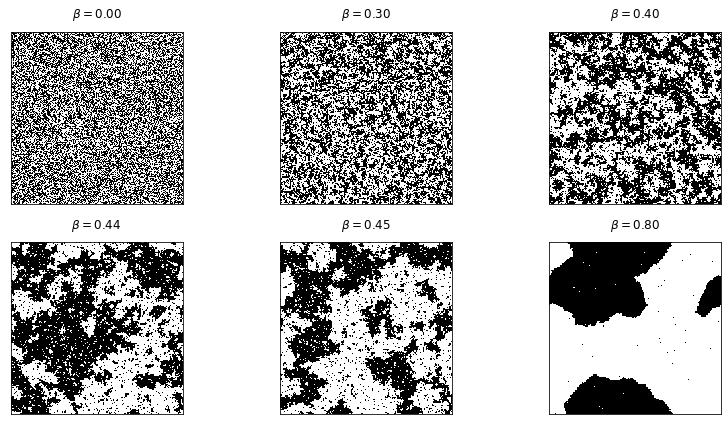

In [3]:
import numpy as np
import matplotlib.pylab as plt

L = 2**8
x = np.random.choice([-1,1],size=(L,L))
betas = [0., 0.3, 0.4, 0.44, 0.45, 0.8]

X = [x.copy()]

for beta in betas[1:]:
    X.append(x.copy())
    for _ in range(100):
        ising_sweep(X[-1], beta)
    
fig, ax = plt.subplots(2, len(betas)//2, figsize=(12, 6))
ax = list(ax.flat)
for a, beta, x in zip(ax, betas, X):
    a.set_title(r'$\beta={0:.2f}$'.format(beta))
    a.matshow(x, cmap=plt.cm.gray_r)
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)
fig.tight_layout()

## Notation and conventions

* Most of the time I will consider a _probability density function_ (pdf) or _probability mass function_ (pmf) $p(x)$ where $x$ could be a parameter vector of a probabilistic model (e.g. in case we want to do computations with the posterior) or the observations from which we want to learn a model. For continuous sample spaces $\mathcal X$, we are dealing with a __pdf__. In case of a discrete sample space $\mathcal X$ (finite or countably infinite), $p(x)$ is a __pmf__. 

* It is generally hard to compute normalized probabilities, but also not really necessary for many sampling algorithms. Therefore, often $p(x)$ is just a nonnegative function, and we assume that the integral $\int_{\mathcal X} p(x)dx < \infty$ or sum $\sum_{x\in\mathcal X} p(x) < \infty$ is finite

* Often, the computation that we need to carry out can be expressed as the __expectation__ of some quantity under a probability. We will denote expectations by

$$
\mathbb{E}_{p}[f] = \int_{\mathcal X} f(x)\, p(x)\,  dx
$$
e.g. the model evidence used in Bayesian model comparison is $\Pr(D|M) = \mathbb E_{\Pr(\theta|M)}[\Pr(D|\theta,M)]$. 

* The notation
\begin{equation}\label{eq:sample_from}
x \sim p(x)
\end{equation}
means that $x$ follows the distribution $p$


At $\beta = \frac{\log(1 + \sqrt 2)}{2} \approx 0.44$, something peculiar happens. The "attractive forces" that tend to align neighboring spins become so dominant that large regions form. Across these regions, all spins have a similar orientation. This is a *phase transition*. Similar phenomena occur also in learning large probabilistic models where the prior and the likelihood often favor distinct regions in parameter space. 

In graphical models such as the Ising model all computations are finite but have an exponential complexity. For a square lattice of length $L$ there are $2^{L^2}$ possible states. Visiting all states is not an option even for small to moderate lattice sizes such as $L=32$. In this case, we have $2^{1024}$ states. Compare this to the number of atoms in the universe which is estimated to be approx. $2^{266}$. As an aside, according to [Eddington](https://en.wikipedia.org/wiki/Eddington_number) the number of electrons in the universe is in fact

$15747724136275002577605653961181555468044717914527116709366231425076185631031296 \approx 2^{263}$ 

Anyways, if each atom were a computing device and running since the Bing Bang, i.e. for $13.5 \text{ billion years} \approx 2^{59} s$, at a rate of $3.3 \text{Gz} =2^{32}$ Hz, then we could have visited $2^{357}$ states. This is only a vanishingly small fraction of the entire state space of the $32\times 32$ Ising model. We would have to wait for $2^{667} \simeq 10^{201}$ universe life times until we had visited all possible states.   

For a thorough discussion read the Chap. 29 in David MacKay's book [Information Theory, Inference, and Learning Algorithms](http://www.inference.org.uk/itprnn/book.pdf).

## Monte Carlo methods

The basic idea of __Monte Carlo methods__ is to use a random process to compute a (deterministic) quantity. That is, we give up deterministic guarantees and satisfy ourselves with statistical guarantees: we resort to gambling (therefore the name "Monte Carlo"). For a historical background on the beginning of modern Monte Carlo methods have a look at the recollections of pioneers Nick Metropolis ([The Beginning of the Monte Carlo Method](https://fas.org/sgp/othergov/doe/lanl/pubs/00326866.pdf)) and Roger Eckhard ([Stan Ulam, John von Neumann,
and the Monte Carlo Method](https://fas.org/sgp/othergov/doe/lanl/pubs/00326867.pdf)). Using a random experiment to compute a quantity is at least as old as [Buffon's needle problem]( https://en.wikipedia.org/wiki/Buffon%27s_needle_problem):

![Buffon's needle](images/McCracken_TheMonteCarloMethod_Fig1.png "Buffon's needle")

Figure from [McCracken: The Monte Carlo Method](https://www.jstor.org/stable/24944647?seq=1#metadata_info_tab_contents). 

The idea of the Monte Carlo method for probabilistic inference is simple: Instead of computing the integral/sum by systematically visiting all possible states in $\mathcal X$, we (randomly) pick those states that are likely to contribute strongly to the sum/integral:

\begin{equation}\label{eq:sampling}
\mathbb{E}_{p}[f] = \int_{\mathcal X} f(x)\, p(x)\,  dx \approx \hat f_S := \frac{1}{S} \sum_{s=1}^S f(x^{(s)})\,\,\,\text{with}\,\,\,  x^{(s)} \sim p(x)
\end{equation}
where $x^{(s)}$ are $S\in\mathbb N$ samples from $p(x)$ (the index $s$ enumerates all samples) and $\hat f_S$ is a *Monte Carlo estimate* or *Monte Carlo approximation* of $\mathbb E_p[f]$. Our hope is that with $S\to\infty$, the approximation becomes better and better. This is indeed the case, as we will see in a second. 

### Monte Carlo as density estimation

The Monte Carlo approximation can also be viewed as a *density estimation* approach since the estimate $\hat f_S$ can be interpreted as the expectation under the approximate probability
\begin{equation}\label{eq:approximate_pdf}
\hat p_S(x) = \frac{1}{S} \sum_{s=1}^S \delta(x - x^{(s)})
\end{equation}
where $\delta(\cdot)$ is the [delta distribution](https://en.wikipedia.org/wiki/Dirac_delta_function): 
\begin{equation}\label{eq:sampling2}
\hat f_S := \frac{1}{S} \sum_{s=1}^S f(x^{(s)}) = \mathbb E_{\hat p_S}[f]
\end{equation}
We approximate the true probability $p(x)$ with a Monte Carlo estimate $\hat p_S(x)$ obtained at $S$ samples $x^{(s)}$ where 

$$
|\hat p_S - p| \to 0\,\,\, \text{for}\,\,\, S\to \infty 
$$

in some appropriate norm $|\cdot|$.

### Why does it work?

#### Unbiasedness

The joint distribution of all Monte Carlo samples is simply a product density, because all samples are generated *independently* of each other:
$$
p_S(x^{(1)}, \ldots, x^{(S)}) = \prod_{s=1}^S p(x^{(s)})
$$

The Monte Carlo estimate $\hat f_S$ is a random quantity, because with each realization of $x^{(1)}, \ldots, x^{(S)}$ we obtain a different result. We can compute the first two moments of $\hat f_S$:

\begin{equation}\label{eq:MCbias}
\mathbb E_{p_S}[\hat f_S] = \frac{1}{S} \sum_{s=1}^S \mathbb{E}_p[f(x^{(s)})] = \mathbb{E}_p[f] =: \mu
\end{equation}
That is, the Monte Carlo estimate of $\mathbb E_p[f]$ is __unbiased__.

How accurate is the estimate on average (i.e. how close do we get to the true value if we run many replications of the sampling procedure)? To answer this question, we compute the variance

\begin{eqnarray}\label{eq:MCvariance}
\nonumber \text{var}[\hat f_S] 
&=& \frac{1}{S^2} \sum_{s,s'} \mathbb{E}_{p_S}\bigl[(f(x^{(s)}) - \mu) (f(x^{(s')}) - \mu)\bigr] \\
\nonumber &=& \frac{1}{S^2} \sum_{s,s'} \delta_{s,s'}\, \mathbb{E}_{p}\bigl[(f(x^{(s)}) - \mu)^2\bigr] \\
&=& \frac{1}{S} \text{var}[f] 
\end{eqnarray}
That is, Monte Carlo error bars shrink like $1/\sqrt{S}$:
\begin{equation}\label{eq:MCerror}
\sigma(\hat f_S) := \sqrt{\text{var}[\hat f_S]} = \sigma(f) / \sqrt{S}
\end{equation}

where the proportionality constant $\sigma(f)=\sqrt{\text{var}[f]}$ depends on the specific estimation problem. In practice, $\sigma(f)$ is not available (after all we are doing Monte Carlo because we cannot do the sum/integrals that are necessary to compute means and variances...). However, we can use Monte Carlo to estimate $\sigma(f)$.

#### Asymptotic guarantees

So far, we studied the behavior of the Monte Carlo estimator for fixed number of samples $S$ and many repetitions. Let us now look at the limit $S\to\infty$. We have (almost surely)

\begin{equation}\label{eq:slln}
\hat f_S \overset{S\to\infty}{\longrightarrow} \mu = \mathbb E_p[f]
\end{equation}

This result is known as the [*strong law of large numbers*](https://en.wikipedia.org/wiki/Law_of_large_numbers).

If $\text{var}[f] < \infty$, then the [__Central limit theorem__ (CLT)](https://en.wikipedia.org/wiki/Central_limit_theorem), a fundamental theorem in Statistics, guarantees that Monte Carlo works:

\begin{equation}\label{eq:CLT}
\hat f_S \overset{S\to\infty}{\longrightarrow} \mathcal N\left(\mathbb E_p[f], \sigma(f)^2/S\right) 
\end{equation}

where $\mathcal N(\mu, \sigma^2)$ is the [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean $\mu$ and variance $\sigma$. 

But these are only statistical, asymptotic guarantees for the convergence of Monte Carlo methods. 

### Application: A slightly silly way to estimate $\pi$

Let us use a simple Monte Carlo approach to estimate $\pi$. We have

\begin{equation}\label{eq:pi}
\pi = \int_{[-1,1]^2} \mathbb 1(x^2 + y^2 < 1)\, \, dx dy = \int_{\mathcal X} f(x, y)\, p(x, y)\, dxdy
\end{equation}

where $\mathbb 1(\cdot)$ is the indicator function. In this example, the distribution $p(x,y)=1/4$ is the uniform distribution over the square $\mathcal X = [-1, 1]^2$ and $f(x, y) = 4\cdot\mathbb 1(x^2 + y^2 < 1)$. We have:

$$
\mathbb E[f] = \pi\,\,\,\text{and}\,\,\,\text{var}[f] = (4-\pi)\, \pi 
$$

This integral can be approximated by:

\begin{equation}\label{eq:pi_MC}
\pi \approx \frac{1}{S} \sum_{s=1}^S f(x^{(s)}, y^{(s)})
\end{equation}

where $(x^{(s)}, y^{(s)})$ are picked randomly from the unit square. The approximate value of $\pi$ is just four times the fraction of sampling points that land in the unit disk.  

Let's code it in Python:

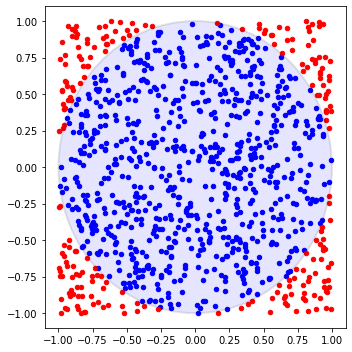

In [4]:
# graphical illustration
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Circle

S = 1000
x = np.random.uniform(-1, +1, size=(2, S))
r = np.sum(x**2, axis=0)
circle = Circle((0.,0.), radius=1., facecolor='b', alpha=0.1, edgecolor='k', lw=2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*x[:,r<=1], color='b', s=20)
ax.scatter(*x[:,r>1], color='r', s=20)
ax.add_patch(circle)
fig.tight_layout()


In [5]:
import numpy as np

def estimate_pi(S):
    """
    Monte Carlo estimate of pi.
    
    Parameters
    ----------
    S : number of samples
    """
    # pick S points from unit square
    x = np.random.uniform(-1, 1, size=(2, int(S)))
    
    # compute squared distance from center
    r = np.sum(x**2, axis=0)
    
    # fraction of points in unit circle
    return 4 * np.mean(r < 1)

How well does this simple Monte Carlo procedure work, if we increase the number of sampling points? 

array([[1.00000000e+03, 3.12000000e+00],
       [2.15443500e+03, 3.19200000e+00],
       [4.64158900e+03, 3.12400000e+00],
       [1.00000000e+04, 3.12900000e+00],
       [2.15443470e+04, 3.14900000e+00],
       [4.64158880e+04, 3.14500000e+00],
       [1.00000000e+05, 3.14300000e+00],
       [2.15443469e+05, 3.14000000e+00],
       [4.64158883e+05, 3.14200000e+00],
       [1.00000000e+06, 3.14200000e+00]])

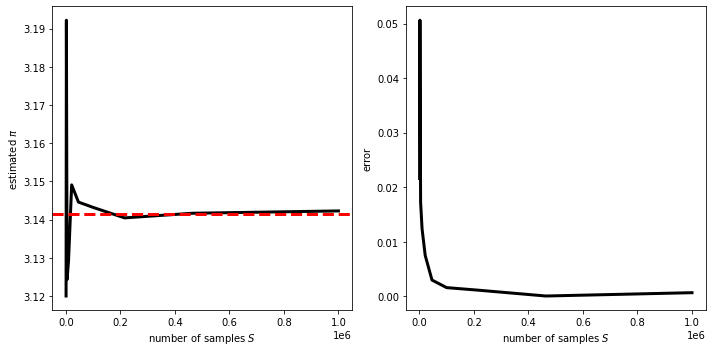

In [6]:
S = np.logspace(3, 6, 10)
estimates = list(map(estimate_pi, S))

kw = dict(xlabel=r'number of samples $S$')
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=kw)

ax[0].plot(S, estimates, color='k', lw=3)
ax[0].axhline(np.pi, ls='--', color='r', lw=3)
ax[0].set_ylabel(r'estimated $\pi$')

ax[1].plot(S, np.fabs(np.array(estimates)-np.pi), color='k', lw=3)
ax[1].set_ylabel(r'error')
fig.tight_layout()
np.round(np.transpose([S, estimates]), 3)

To quantify the statistical error, we run multiple replications of the procedure:

In [7]:
n_rep = 200
estimates = np.array([list(map(estimate_pi, S)) for _ in range(n_rep)])

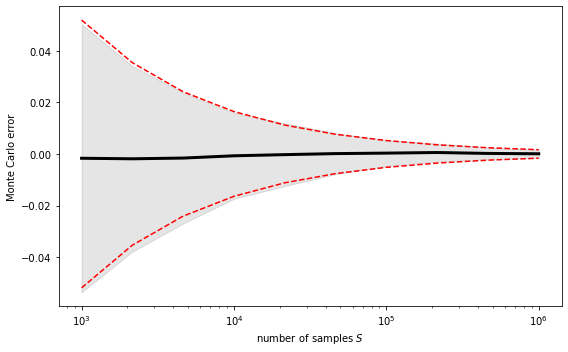

In [8]:
mean_pi = estimates.mean(0)
std_pi = estimates.std(0)
var = np.pi*(4.-np.pi)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), subplot_kw=kw)
ax.fill_between(S, mean_pi - np.pi + std_pi, mean_pi - np.pi - std_pi,
                color='k', alpha=0.1)
ax.plot(S, mean_pi - np.pi, lw=3, color='k')
ax.plot(S, -(var/S)**0.5, color='r', ls='--')
ax.plot(S, +(var/S)**0.5, color='r', ls='--')
ax.set_ylabel(r'Monte Carlo error')
ax.semilogx()
fig.tight_layout()

# Lecture 2: Direct Sampling Methods


## Outline

* Can we beat the curse of dimensionality?
* Random number generation
* Direct sampling by variable transformation methods

### A warning

Alan Sokal ([Monte Carlo methods in statistical mechanics](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.49.4444&rep=rep1&type=pdf)):

> Monte Carlo is an extremely bad method; it should be used only when all alternative methods are worse.

Why is this so? As we saw Monte Carlo methods have a statistical error that roughly scales with $1/\sqrt{\text{computational budget}}$. Typically, for low-dimensional problems other numerical methods scale much better. For example, even simple quadrature methods such as [Simpon's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) have an error that scales with $\mathcal O(S^{-4/D})$ rather than $\mathcal O(S^{-1/2})$ where $D$ is the dimension of the integrand. This means that for $D\le 8$, Simpson's rule will be more efficient than Monte Carlo. However, in higher dimensions this is often no longer the case, and we have to resort to Monte Carlo methods. 

Our specific application of Monte Carlo (estimation of $\pi$) is a clear case where Sokal's warning applies. If we use numerical quadrature, we can achieve a high accuracy with much less effort: 

In [9]:
from scipy.integrate import quad

val, err, info = quad(lambda x: (1-x**2)**(1/2), 0., 1., full_output=True)

print(f'estimate: {4*val} based on {info["neval"]} points')
print(f'accuracy: {abs(4*val-np.pi)}')

estimate: 3.1415926535897922 based on 231 points
accuracy: 8.881784197001252e-16


## Do we beat the curse of dimensionality?

Although Monte Carlo doesn't depend explicitly on the dimension of the sample space, it does so in practice. If we go back to our expression for the Monte Carlo error (Eq. \ref{eq:MCerror})

$$
\sigma(\hat f_S) = \sigma(f) / \sqrt{S}
$$

for a generalized version of the $\pi$ estimation approach, then the dependence on the dimension of the sampling problem becomes apparent.

In the generalized version, we estimate the volume of a [$D$-dimensional unit-ball](https://en.wikipedia.org/wiki/Ball_(mathematics)) $V(D)$ by the following Monte Carlo procedure:

* Pick a point from a unit hypercube (assuming that this can be done easily)
* Check if point lies inside ball

Written out in equations where $x$ is now a $D$-dimensional vector:

$$
V(D) = \int \mathbb 1(\|x\| \le 1) dx = \int p(x)\, f(x)\, dx
$$
with 
$$
f(x) = 2^D\, \mathbb 1(\|x\| \le 1)\,\,\, \text{and} \,\,\, p(x) = \frac{1}{2^D} \mathbb 1(x \in [-1, 1]^D)
$$

We can compute how the Monte Carlo error scales by evaluating the mean and variance of $f$:

\begin{eqnarray*}
\mathbb E[f] &=& V(D)\\
\text{var}[f] &=& \mathbb E[f^2]  - V^2(D) = 2^D V(D) - V^2(D) = \bigl(2^D - V(D)\bigr)\, V(D) 
\end{eqnarray*}

Therefore, the error of the above Monte Carlo procedure scales with $D$ as follows:

$$
\sigma(\hat f) = \sqrt{\frac{\bigl(2^D - V(D)\bigr)\, V(D)}{S}} 
$$


We [have](https://en.wikipedia.org/wiki/Volume_of_an_n-ball): 

$$
V(D) = \frac{\pi^{D/2}}{\Gamma(D/2+1)} \approx \frac{1}{\sqrt{D\pi}} \left(\frac{2\pi e}{D}\right)^{D/2}
$$

Therefore, overall:

$$
\sigma(\hat f) \approx (8e\pi/D)^{D/4} \bigl/\bigr. (\pi D)^{1/4} \sqrt{S}
$$

In [10]:
import numpy as np
import matplotlib.pylab as plt

from scipy.special import gammaln, lambertw


def estimate_volume(D, S):
    """
    D : dimension of embedding space
    S : number of sampling points
    """
    volcube = 2**D
    points = np.random.uniform(-1., 1., size=(S, D))
    distance = np.linalg.norm(points, axis=1)
    return np.mean(distance <= 1.) * volcube


def volball(D):
    """
    Volume of a unit ball in D dimensions
    See: https://en.wikipedia.org/wiki/Volume_of_an_n-ball
    """
    logvol = 0.5 * D * np.log(np.pi) - gammaln(D/2 + 1)
    return np.exp(logvol)

In [11]:
S = 10000
n_trials = 1000

dims = np.arange(1, 30)
vols = np.array([[estimate_volume(D, S) for _ in range(n_trials)] for D in dims])

[2.         3.14159265 4.1887902  4.9348022  5.26378901 5.16771278
 4.72476597 4.05871213 3.2985089 ]


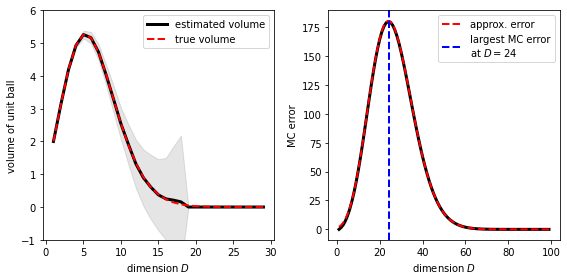

In [12]:
# show results
dims = np.arange(len(vols))+1
kw = dict(xlabel=r'dimension $D$')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=kw)
ax[0].fill_between(dims, vols.mean(1) + vols.std(1), 
                   vols.mean(1) - vols.std(1), color='k', alpha=0.1)
ax[0].plot(dims, vols.mean(1), lw=3, color='k', label='estimated volume')
ax[0].plot(dims, volball(dims), lw=2, color='r', ls='--', label='true volume')
ax[0].set_ylabel('volume of unit ball')
ax[0].legend()
ax[0].set_ylim(-1., 6.)

# Monte Carlo error
dims = np.arange(1, 100)
err = np.sqrt((2.**dims - volball(dims)) * volball(dims))
approx_err = (np.pi*dims)**(-1/4) * (8*np.pi*np.e/dims)**(dims/4)
dim_crit = -1/lambertw(-1/(8*np.pi)).real
ax[1].plot(dims, err, lw=3, color='k')
ax[1].plot(dims, approx_err, lw=2, color='r', ls='--', label='approx. error')
ax[1].axvline(dim_crit, lw=2, color='b', ls='--', label='largest MC error\n' + r'at $D=24$')
ax[1].set_ylabel('MC error')
ax[1].legend()
fig.tight_layout()
print(volball(np.arange(1, 10)))

The Monte Carlo error depends on the dimension in a non-trivial fashion. The dimension with the largest scaling factor $\sigma(f)$ is approximately

$$
D_{\text{max. error}} \approx -1 / W(-1/(8\pi)) \approx 24
$$

where $W$ is the [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function). Another problem is that the chance of hitting a point in the unit ball by sampling from the hypercube $[-1, 1]^D$ dwindles dramatically as $D$ decreases, since

$$
\text{acceptance rate} = \frac{\text{ volume ball}}{\text{ volume cube}} = \frac{V(D)}{2^D} \to 0
$$

That is, although the Monte Carlo error decays beyond $D > 24$, the generation of a point inside the ball becomes extremely rare. 

## Pros and Cons of  Monte Carlo 

__Pros__ of the Monte Carlo method:

* Monte Carlo methods are widely applicable. For instance, $f$ and $p$ need not be continuous, differentiable etc.

* Monte Carlo is often easy to implement.

* Monte Carlo *can* work well in multiple dimensions, where grid-based methods can be inefficient/inapplicable. This is supported by the "$\mathcal O(1/\sqrt{S})$ rate of convergence" which is independent of the dimension.

__Cons__:

* Even though the Monte Carlo rate is usually $\mathcal O(1/\sqrt{S})$, the constants involved may grow exponentially in dimension. 

* Deterministic methods may have better rate of convergence than the Monte Carlo rate $1/\sqrt{S}$ (but may also deteriorate faster when dimension increases).

* Monte Carlo estimate is always random, so we never have guaranteed tolerance, but only statistical evidence (consistent confidence intervals at best).

# Pseudo-random Number Generators

Monte Carlo Estimation depends on the availability of uniform random numbers (we needed these in order to generate points in the hypercube). One possibility to generate random numbers is to do random experiments such as rolling a die. Swiss Astronomer [Rudolf Wolf](https://en.wikipedia.org/wiki/Rudolf_Wolf) rolled a pair of dice 20000 times (see e.g. [Wolf dice data](https://www.lesswrong.com/posts/zd89utY4afA59p58k/wolf-s-dice)). He also performed [Buffon's needle](https://en.wikipedia.org/wiki/Buffon%27s_needle_problem) experiment to verify the value of $\pi$. Francis Galton designed a device, the quincunx or [Galton board](https://en.wikipedia.org/wiki/Bean_machine), for generating randomly distributed balls or beans that follow a Gaussian distribution (in fact Binomial distribution). Here is a nice [animation](https://twitter.com/CentrlPotential/status/1332124614391173123) and an interactive [online tool](https://www.mathsisfun.com/data/quincunx.html). The RAND cooperation used an electrical roulette wheel to generate 1 million random numbers that were published as a [book](https://en.wikipedia.org/wiki/A_Million_Random_Digits_with_100,000_Normal_Deviates). More hardware implementations for generating random numbers have been developed (see [wikipedia](https://en.wikipedia.org/wiki/Hardware_random_number_generator) for more information). For example, [RDRAND](https://en.wikipedia.org/wiki/RDRAND) extracts random numbers from an Intel on-chip hardware random number generator. 

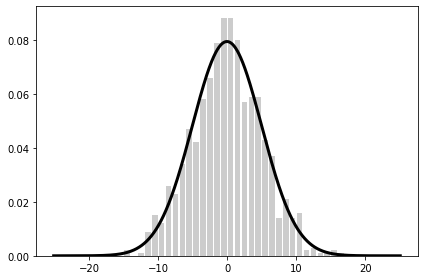

In [13]:
# simulation of Galton board

class GaltonBoard:
    
    # directions into which ball can jump
    left, right = -0.5, +0.5    
    
    def __init__(self, n_beans=1e4, n_pegs=20):
        """
        n_beans : int or float
          number of beans that will run through board
        n_pegs : int > 0
          number of pegs from top to bottom
        """
        self.n_beans = int(n_beans)
        self.n_pegs = int(n_pegs)

        
    def simulate_jumps(self):
        """Simulate all jumps as a random walk. """
        return np.random.choice([GaltonBoard.left, GaltonBoard.right], 
                                size=(self.n_beans, self.n_pegs))
    
    def sample_positions(self):
        """Simulate jumps and return final position of beans by adding up
        all steps for left/right. 
        """
        return self.simulate_jumps().sum(1)

    
board = GaltonBoard(n_beans=1e3, n_pegs=99)

# accumulate
x, counts = np.unique(board.sample_positions(), return_counts=True)

# convert counts to probability
p = counts.astype('d') / counts.sum()

# fit Gaussian
mu = np.dot(p, x)
sigma = np.dot(p, (x-mu)**2)**(1/2)
t = np.linspace(-1., 1., 1000) * 5 * sigma + mu
g = np.exp(-0.5 * (t-mu)**2/sigma**2 - 0.5 * np.log(2*np.pi*sigma**2))
g *= np.diff(x).min()

# compare results graphically
fig, ax = plt.subplots(1, 1)
ax.bar(x, p, color='k', alpha=0.2)
ax.plot(t, g, lw=3, color='k')
fig.tight_layout()

## Linear congruential generator

[Pseudo random number generators (PRNGs)](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) are typically used to produce uniformly distributed pseudo random numbers. One of the standard PRGNs is the [__linear congruential generator__ (LCG)](https://en.wikipedia.org/wiki/Linear_congruential_generator) introduced by [D. H. Lehmer](https://en.wikipedia.org/wiki/D._H._Lehmer). LCG uses a recurrence relation to generate a new random number $x^{(s+1)}$ from a current one $x^{(s)}$:

$$
x^{(s+1)} = (a x^{(s)} + c)\, \text{mod}\, m 
$$

with  

* __modulus__ $m > 0$

* __multiplier__ $a$ where $0 < a < m$

* __increment__ $c$ where $0 \le c < m$

* __seed__ $x^{(0)}$ where $0 \le x^{(0)} < m$

This is an iterative linear mapping combined with the modulo operation resulting in a discontinuity as soon as the next number escapes from the interval $[0,m-1]$. The initial value $x^{(0)}$ is called the __random seed__ or just __seed__. LCGs produce *periodic* random numbers: as soon as a number is visited twice it will produce the exact same sequence of random numbers. This will happen after at most $m$ iterations. Therefore, the period of the sequence is $m$ or smaller, and we have to choose large $m$ in order to not exhaust our random numbers too quickly. Moreover, we should also choose the increment $c$ and multiplier $a$ such that they are smaller than $m$. By construction, $x^{(s)}\in[m]$ and $u^{(s)} = x^{(s)}/m$ are uniformly distributed random numbers in $[0,1)$. Among the most widely used PRNGs is the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). 

In [14]:
"""
Pseudo random number generator
"""
import numpy as np
import matplotlib.pylab as plt

from csb.statistics import autocorrelation


class PRNG:
    """PRNG

    Pseudo-random number generator implemented as iterator. Using a linear 
    congruential generator (LCG) to generate random numbers. Default settings
    for modulus, multiplier and period are taken from Numerical Recipes. 
    
    Example
    -------
    >>> prng = PRNG(maximum=1e4)
    x = list(prng)
    >>> len(x)
    10000

    Details:
    * https://en.wikipedia.org/wiki/Linear_congruential_generator
    """
    def __init__(self, m=2**32, a=1664525, c=1013904223, seed=10, maximum=1e6):
        """
        Parameters
        ----------
        m : int > 0
            modulus or period

        a : int > 0
            multiplier (should be smaller than modulus)

        c : int >= 0
            increment (should be smaller than modulus)

        seed : int >= 0
            initial state (should be smaller than modulus)

        maximum : float or int
            maximum number of random numbers to be generated by PRNG
        """
        def check_int(i, lower=0, upper=None):
            valid = type(i) is int and i >= lower
            if upper is not None:
                valid &= i < upper
            return valid
        
        msg = '"{0}" must be int >= {1}'
        assert check_int(m, 1), msg.format('m', 1)
        assert check_int(a, 1, m), msg.format('a', 1)
        assert check_int(c, 0, m), msg.format('c', 0)
        assert check_int(seed, 0, m), msg.format('seed', 0)
        
        self.a, self.c, self.m, self.seed = a, c, m, seed
        self._max = int(maximum)
        
        self._reset()
        
    def _reset(self):        
        self.x = self.seed
        self._counter = 0
        
    def __next__(self):
        """
        Using recurrence relation 

            X_{n+1} = (a X_n + c) mod m

        to generate new random number
        """
        if self._counter >= self._max:
            raise StopIteration
        
        self.x = (self.a * self.x + self.c) % self.m
        self._counter += 1

        return self.x
        
    def __iter__(self):
        self._reset()
        return self


class Uniform(PRNG):
    """Pseudo-random numbers between 0 and 1. """
    def __next__(self):
        return super().__next__() / float(self.m)

The quality of a LCG depends on the choice of the four "magic numbers" $a, c, m$ and $x^{(0)}$. Let us look at what happens for small periods $m$ (you can also do this with a nice [online app](https://demonstrations.wolfram.com/LinearCongruentialGenerators/) and another [app](https://demonstrations.wolfram.com/LinearCongruentialSequences/)). Let's do it with our Python code:

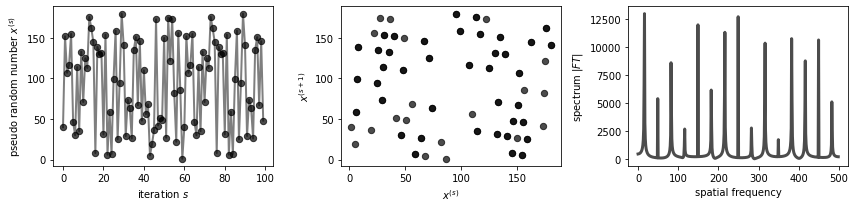

In [15]:
prng = PRNG(m=181, a=40, c=0, seed=1, maximum=1000)
x = np.array(list(prng))
X = np.fft.fft(x)

kw = dict(s=40, color='k', alpha=0.7)
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(np.arange(100), x[:100], **kw)
ax[0].plot(x[:100], color='k', lw=2, alpha=0.5)
ax[0].set_xlabel(r'iteration $s$')
ax[0].set_ylabel(r'pseudo random number $x^{(s)}$')

ax[1].scatter(x[:100], x[1:101], **kw)
ax[1].set_xlabel(r'$x^{(s)}$')
ax[1].set_ylabel(r'$x^{(s+1)}$')

ax[2].plot(np.abs(np.fft.fftshift(X))[1:len(x)//2], 
                  lw=3, color='k', alpha=0.7)
ax[2].set_xlabel('spatial frequency')
ax[2].set_ylabel(r'spectrum $|FT|$')

fig.tight_layout()

As shown in this simple example, LCGs can suffer from serious deficits and biases. A famous example is IBM's [RANDU](https://en.wikipedia.org/wiki/RANDU) algorithm, according to Donald Knuth a "truly horrible" algorithm. A whole array of [*randomness tests*]( https://en.wikipedia.org/wiki/Randomness_tests) has been developed ever since. For example, in the [spectral test](https://en.wikipedia.org/wiki/Spectral_test) successive random numbers are plotted against each other, thereby revealing nonrandom structures in the pseudo random number sequence. 

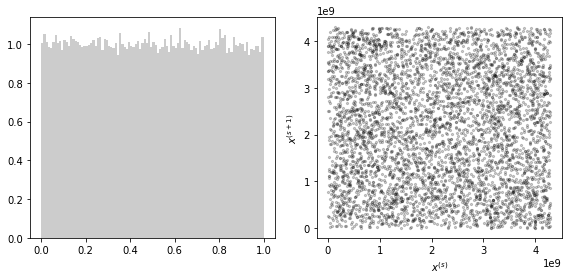

In [16]:
# LCG from Numerical Recipes
n_samples = 1e5
prng = PRNG(maximum=n_samples)
x = np.array(list(prng))   
u = x / float(prng.m)

kw = dict(s=5, color='k', alpha=0.2)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(u, bins=100, density=True, color='k', alpha=0.2)
ax[1].scatter(x[:5000], x[1:5001], **kw)
ax[1].set_xlabel(r'$x^{(s)}$')
ax[1].set_ylabel(r'$x^{(s+1)}$')
fig.tight_layout()    

## Sampling a discrete model

Assuming that we have a good source for pseudo random numbers, let us first look at how to use these for sampling a *discrete model*. The sample space is finite or countably infinite: $\mathcal X = \{x_1, \ldots, x_N\}$, where $N=\infty$ is also possible. Without loss of generality we assume $p_i>0$ (zero-probability states are excluded from the sample space). 

How can we use uniform random numbers from $[0, 1]$ to generate samples from $p$? For given $u\sim \mathcal U(0,1)$ pick state $i\in[N]$ such that

\begin{equation}\label{eq:discrete_sampling}
    i = \min\bigl\{j \in\mathbb N\, :\, \sum_{k=1}^j p_k \ge u  \bigr\}
\end{equation}

Here and in the following $\mathcal U(0,1)$ denotes the uniform distribution over the unit interval, i.e. $x\sim U(0,1)$ has density $p(x) = \mathbb 1(0 < x < 1)$.  

Why is this procedure correct? Let us call $c_i = \sum_{k=1}^i p_k$, then $c_1 = p_1 > 0$ and $c_N = 1$. Moreover, define $c_0:= 0$. All $c_i\in(0,1]$ (except $c_0$) and sorted $c_{i-1} < c_i$ (since all $p_i>0$). So the intervals $I_i=[c_{i-1}, c_i)$ form a partition of $[0,1)$ and the uniform distribution $\mathbb 1\bigl(x\in[0,1)\bigr)$ can be written as a mixture of uniform distributions: 

$$
\mathbb 1\bigl(x\in[0,1)\bigr) = \sum_{i=1}^{N} \mathbb 1\bigl(x\in[c_{i-1}, c_{i})\bigr)
$$


Criterion (Eq. \ref{eq:discrete_sampling}) picks the interval with $u\in[c_{i-1}, c_{i})=:I_i$. The length of each interval $I_i$ is $c_i - c_{i-1} = p_i$, and equal to the chance of landing in $I_i$. Therefor the generated $x_i$ will follow $p$.   

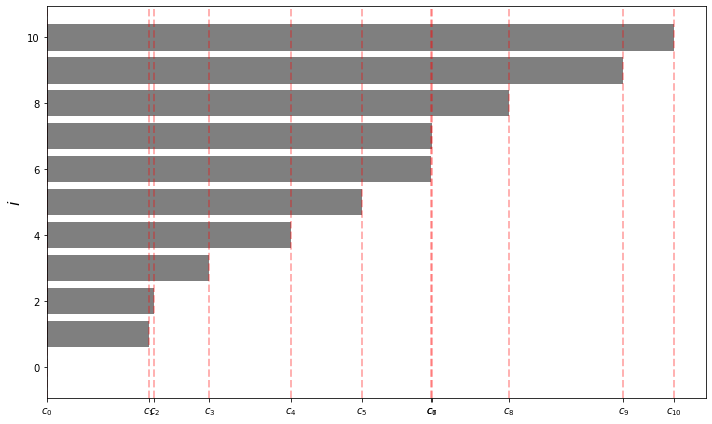

In [17]:
# illustration discrete sampling
import numpy as np
import matplotlib.pylab as plt

N = 10
p = np.random.random(N)
p /= p.sum()
i = np.arange(N+1)

c = np.append(0., np.add.accumulate(p))

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(i, c, color='k', alpha=0.5)
ax.set_ylabel(r'$i$', fontsize=16)
ax.set_xticks(c)
ax.set_xticklabels([r'$c_{{{}}}$'.format(ii) for ii in i])
for cc in c:
    ax.axvline(cc, ls='--', color='r', lw=2, alpha=0.3)
fig.tight_layout()

### Sampling from the Poisson distribution

The Poisson distribution is a pmf over the sample space $\mathbb N$, i.e. $x=0, 1, 2, \ldots$ and defined as

\begin{equation}\label{eq:poisson}
p(x) = \frac{\lambda^x}{x!} e^{-\lambda}, \,\,\, \lambda > 0
\end{equation}

the parameter $\lambda$ is called *rate*. The mean and variance of $x$ are

$$
\mathbb E[x] = \lambda, \,\,\, \text{var}[x] = \lambda\,. 
$$

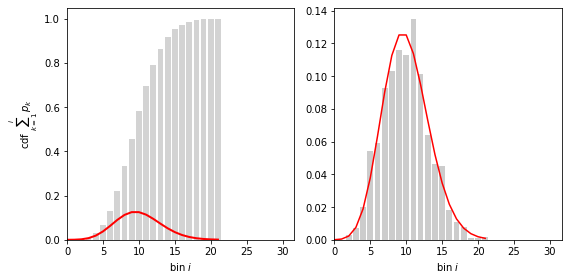

In [18]:
# Sampling from the Poisson distribution
# - this is how it's *not* done in practice -

import numpy as np
import matplotlib.pylab as plt

from scipy.special import gammaln


def sample_poisson(S, rate=1., return_cdf=True):
    """
    S : number of samples
    rate : rate of Poisson distribution
    """
    # uniform random numbers
    u = np.random.random(int(S))
    i = np.argsort(u)
    
    # array storing samples
    x = -np.ones(u.shape, dtype='i')
    
    # building up cdf
    cdf = [0.]
    
    # stepping through sorted list of uniform random numbers
    k = 0
    for v, j in zip(u[i], i):
        while v > cdf[k]:
            k += 1
            pmf = np.exp(k * np.log(rate) - rate - gammaln(k+1))
            cdf.append(cdf[-1] + pmf)
        x[j] = k
        
    if return_cdf:
        return x, np.array(cdf)
    return x

rate = 10.
limits = 0., 10 * rate**0.5
x, cdf = sample_poisson(1e3, rate)
k = np.arange(len(cdf))
pmf = np.exp(k * np.log(rate) - rate - gammaln(k+1))

bins, hist = np.unique(x, return_counts=True)
hist = hist.astype('d') / hist.sum()

settings = dict(xlim=limits, xlabel=r'bin $i$')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=settings)
ax[0].plot(k, pmf, color='r', lw=2)
ax[0].bar(k, cdf, color='lightgrey')
ax[0].set_ylabel(r'cdf $\sum_{k=1}^i\, p_k$')
ax[1].bar(bins, hist, color='k', alpha=0.2)
ax[1].plot(k, pmf, color='r')
fig.tight_layout()

# Variable transformation methods

We will now move on to continuous sample spaces. Assuming that we can generate uniform random samples from $\mathcal U(0, 1)$, how can we use these samples to generate samples from a non-uniform distribution $p(x)$? In the last section we saw how to do this for pmfs (although it might not be practical for large finite models such as Ising models). 

Let's first look at the simplest version of sampling from a pdf where the sample space is one-dimensional. So we are looking for ways of how to transform a single uniformly distributed variable $u \sim \mathcal U(0, 1)$ to $x \sim p(x)$. To design such as method, we first need to understand how probability distributions transform under parameter transformations. 

## Transformation of probability distributions

Let $h$ be a *one-to-one mapping* between two one-dimensional sample spaces $h: \mathcal X \to \mathcal Y$, and $h^{-1}$ is the inverse function. If $x\sim p_x(x)$, what is the distribution $p_y(y)$ of $y=h(x)$? To answer this question let us compute the distribution $p_y$:

\begin{equation}\label{eq:transform1d}
p_y(y) = \int_{\mathcal X} \delta(y - h(x))\, p_x(x)\, dx = \int_{\mathcal X} \frac{1}{|h'(x)|} \delta(x - h^{-1}(y))\, p_x(x)\, dx = \frac{p_x(h^{-1}(y))}{h'(h^{-1}(y))}
\end{equation}

where we used the transformation property of the [delta distribution](https://en.wikipedia.org/wiki/Dirac_delta_function). The transformation rule guarantees that normalized pdfs transform into normalized pdfs. 

This result can be generalized to multiple dimensions. Let $h$ be an invertible one-to-one mapping between two $D$ dimensional sample spaces. Assume further that $h$ is continuously differentiable such that the Jacobian

$$
\nabla h(x) = \left(\frac{\partial h_i(x)}{\partial x_j} \right)_{i,j}
$$

is everywhere invertible in $\mathcal X$, i.e. $\text{det}(\nabla h(x)) \not= 0$ for all $x\in \mathcal X$. Then $y=h(x)$ has density

$$
p_y(y) = \left\{ \begin{array}{c c}
p_x(h^{-1}(y)) \, |\text{det}(\nabla h^{-1})(y)|, & y \in h(\mathcal X) \\
0, & y \notin h(\mathcal X)
\end{array}\right.
$$

## Inversion method

The [*inversion method*](https://en.wikipedia.org/wiki/Inverse_transform_sampling) is a simple variable transformation method. Let $p(x)$ be a pdf over a sample space $\mathcal X \subset \mathbb R$, then the [*cumulative distribution function* (cdf)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) is:

\begin{equation}\label{eq:cdf}
P(y) = \Pr(x \le y) = \mathbb E_p[x \le y] = \int^y_{-\infty} p(x)\, dx
\end{equation}

this is the continuous analog of $c_i$ defined above in the section on sampling discrete models. By construction, $P(x) \in [0, 1]$ for $x \in\mathcal X$. $P(x)$ is continuous and strictly increasing and therefore invertible. Inverse transform sampling uses the following mathematical fact:

\begin{equation}\label{eq:inversion_method}
x = P^{-1}(u) \sim p(x)\,\,\,\text{for}\,\,\, u\sim\mathcal U(0,1) 
\end{equation}

That is, we can generate random samples from $p(x)$ by generating uniformly distributed random numbers in $[0, 1]$ and map them to $\mathcal X$ with the inverse of the cdf $P^{-1}$. To see that this is a valid sampling procedure, let us compute the distribution of $x=P^{-1}(u)$ using the transformation rule (Eq. \ref{eq:transform1d}): We have

$$
\frac{d\, P^{-1}(u)}{d\, u} = \frac{1}{P'(P^{-1}(u))} = \frac{1}{p(P^{-1}(u))}
$$

Plugging this expression into (Eq. \ref{eq:transform1d}) yields

$$
p_x(x) = \frac{p_u(P(x))}{(P^{-1})'(P(x))} = \frac{1}{1 / p(x)} = p(x)
$$

*Example*: Let us apply inverse transformation sampling to the exponential distribution

$$
p(x) = \lambda \, \exp\{-\lambda x\}, \,\,\, \lambda > 0, \, \mathcal X = \mathbb R_+
$$

The cumulative distribution function is

$$
\text{cdf}(x) = \int^x_0 \lambda e^{-\lambda t} \, dt = 1 - e^{-\lambda x} 
$$

and its inverse: 

$$
\text{cdf}^{-1}(u) = - \frac{1}{\lambda} \log(1-u) 
$$

Since $1-u \sim \mathcal U(0,1)$ if $u \sim \mathcal U(0,1)$, we can generate exponentially distributed random variables as follows:

$$
x^{(s)} = - \frac{\log u^{(s)}}{\lambda}, \,\,\, u^{(s)} \sim \mathcal U(0,1)
$$

Some more examples:

|name        |pdf              $p(x)$  |cdf            $P(x)$  |inversion           |
|------------|-------------------------|----------------------|--------------------|
|[Exponential](https://en.wikipedia.org/wiki/Exponential_distribution) | $\lambda e^{-\lambda x}$ | $1 - e^{-\lambda x}$ | $-\log(u)/\lambda$ | 
|[Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution)      |$\frac{\sigma}{\pi(x^2 + \sigma^2)}$ | $\frac{1}{2} + \frac{1}{\pi} \arctan(x/\sigma)$ | $-\sigma\tan(\pi(u-0.5))$ | 
|[Rayleigh](https://en.wikipedia.org/wiki/Rayleigh_distribution)  | $\frac{x}{\sigma^2} e^{-x^2/2\sigma^2}$ | $1- e^{-x^2/2\sigma^2}$ | $\sigma\,\sqrt{-2\log u}$ |
|Triangular | $2 (1 - x/a)/a, \, x\in[0,a]$ | $2 (x - x^2/2a)$ | $a(1-\sqrt{u})$ | 
|[Pareto](https://en.wikipedia.org/wiki/Pareto_distribution)| $a\,b^a / x^{a+1}, \, x\ge b$ | $1-(b/x)^a$ | $b\, u^{-1/a}$ | 

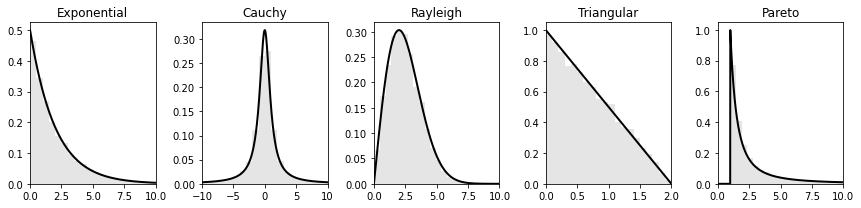

In [19]:
# some examples
import numpy as np
import matplotlib.pylab as plt


class PDF:

    def __init__(self, **params):
        for name, value in params.items():
            setattr(self, name, float(value))
    
    def sample(self, n=None):
        u = np.random.random(int(n))
        return self._invert(u)
    
    def __call__(self):
        pass

    def _invert(self, u):
        pass

    
class Exponential(PDF):
    
    def __init__(self, _lambda=1.):
        super().__init__(_lambda=_lambda)
        
    def __call__(self, x):
        return self._lambda * np.exp(-self._lambda*x)
    
    def _invert(self, u):
        return -np.log(u)/self._lambda
    
    @property
    def support(self):
        return 0., 5 / self._lambda

    
class Cauchy(PDF):
    
    def __init__(self, sigma=1.):
        super().__init__(sigma=sigma)
        
    def __call__(self, x):
        return self.sigma / np.pi / (x**2 + self.sigma**2)
    
    def _invert(self, u):
        return self.sigma * np.tan(np.pi*(u-0.5))
    
    @property
    def support(self):
        return -10., +10.

    
class Rayleigh(PDF):

    def __init__(self, sigma=1.):
        super().__init__(sigma=sigma)

    def __call__(self, x):
        t = (x/self.sigma)
        return t * np.exp(-0.5*t**2) / self.sigma

    def _invert(self, u):
        return self.sigma * np.sqrt(-2*np.log(u))

    @property
    def support(self):
        return 0., 5 * self.sigma


class Triangular(PDF):

    def __init__(self, a=1.):
        super().__init__(a=a)

    def __call__(self, x):
        return 2 * (1 - x/self.a) / self.a

    def _invert(self, u):
        return self.a * (1-np.sqrt(u))

    @property
    def support(self):
        return 0., self.a


class Pareto(PDF):

    def __init__(self, a=1., b=1.):
        super().__init__(a=a, b=b)

    def __call__(self, x):
        return self.a * self.b**self.a / (x**(self.a+1) + 1e-100) * (x>=self.b)

    def _invert(self, u):
        return self.b / u**(1/self.a)

    @property
    def support(self):
        return 0., 10 * self.b
        return self.b, 10 * self.b
    
    
pdfs = [Exponential(_lambda=0.5), Cauchy(), Rayleigh(sigma=2.),
        Triangular(a=2.), Pareto()]

S = int(1e4)

kw = dict(bins=20, color='k', alpha=0.1, density=True)
fig, ax = plt.subplots(1, len(pdfs), figsize=(12, 3))

for a, pdf in zip(ax, pdfs):

    x = np.linspace(*(pdf.support + (1000,)))
    y = pdf.sample(S)
    y = y[(y > x.min()) & (y < x.max())]

    a.set_title(pdf.__class__.__name__)
    a.plot(x, pdf(x), lw=2, color='k')
    a.hist(y, **kw)
    a.set_xlim(*pdf.support)
    
fig.tight_layout()
    

In principle, the inverse transformation approach (Eq. \ref{eq:inversion_method}) generalizes to multiple dimensions (see, for example, Murray Rosenblatt: [Remarks on a Multivariate Transformation](https://www.jstor.org/stable/2236692?seq=1#metadata_info_tab_contents)):

\begin{eqnarray*}\label{eq:multivariate_transform}
%
P_1(x_1') &=& \Pr(x_1 < x_1') = \int \mathbb 1(x_1 \le x_1')\, p(x_1, \ldots, x_D)\, dx_1 \cdots dx_D \\
%
P_2(x_2'\mid{}x_1) &=& \Pr(x_2 < x_2' \mid{}x_1) = \int \mathbb 1(x_2 \le x_2')\, p(x_2, \ldots, x_D\mid{}x_1)\, dx_2 \cdots dx_D \\
 &\vdots&  \\
P_D(x_D'\mid{}x_{D-1}, \ldots, x_{1}) &=& \Pr(x_D < x_D'\mid{}x_{D-1}, \ldots, x_{1}) = \int \mathbb 1(x_D \le x_D')\, p(x_D\mid{}x_{D-1}, \ldots, x_{1})\, dx_D \\
\end{eqnarray*}

However, only in very rare cases is it possible to compute the multivariate cumulative distribution function in higher dimensional spaces, let alone invert it in closed form. 

So this expression is mostly of theoretical interest to us. Nevertheless, it is curious to see that multivariate pdfs can in principle be mapped to a uniform distributions over the hypercube: 

$$
u_i = P_i(x_i\mid{}x_{i-1}, \ldots x_{1}), \,\,\, i=1, \ldots, D
$$

By construction $u=(u_1, \ldots, u_D) \in [0, 1]^D$, and the pdf of $u$ is

$$
p_u(u) = p_x(x(u)) \prod_i \biggl|\frac{d u_i}{d x_i}\biggr|^{-1} = 1
$$

since the Jacobian matrix is triagonal (so its determinant is just a product over the diagonal elements) and 

$$
p(x_1, \ldots, x_D) = p(x_D \mid{} x_{D-1}, \ldots, x_{1}) \cdots p(x_2\mid{}x_1) \, p(x_1)
$$

## Variable transformation method

Sometimes one can find a transformation of the sample space such that the new distribution is easier to sample. A specific example is the [Box-Muller method]( https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) for generating samples from a standard Gaussian distribution:

$$
p(x) = \frac{1}{\sqrt{2\pi}} \exp\bigl\{-x^2/2\bigr\}
$$

where $x \in \mathbb R$. The first trick is to make the problem seemingly more complicated by transforming it to a two-dimensional distribution by introducing $y$ which also follows a standard Gaussian distribution. That is, 

$$
p(x,y) = \frac{1}{2\pi} \exp\bigl\{-(x^2+y^2)/2 \bigr\}\, .
$$

Because $p(x, y)$ depends on $x$ and $y$ only through their distance from the origin $r = \sqrt{x^2 + y^2}$, it makes sense to transform $(x, y)$ to polar coordinates:

$$
\begin{pmatrix} x \\ y \end{pmatrix} = 
\begin{pmatrix} r\cos\varphi \\ r\sin\varphi \end{pmatrix}
$$

with the new sample space $[0, \infty) \times [0, 2\pi]$. The Jacobian of the parameter transformation is

$$
\frac{\partial (x, y)}{\partial (r, \varphi)} = 
\begin{pmatrix}
    \cos\varphi & -r\sin\varphi \\
    \sin\varphi & r\cos\varphi \\
\end{pmatrix}
$$

with determinant
$$
\left|\frac{\partial (x, y)}{\partial (r, \varphi)}\right| = r
$$

Therefore,

$$
p(r, \varphi) = \frac{r}{2\pi} e^{-r^2/2} = p(r)\, p(\varphi)
$$

with $p(\varphi) = \frac{1}{2\pi} \mathbb 1\bigl(\varphi\in[0, 2\pi]\bigr)$. 

The cdf of $p(r)$ is
$$
\int_0^r t e^{-t^2/2}\, dt = e^{-t^2/2} \biggl|_r^0 \biggr. = 1 - e^{-r^2/2}
$$

We can obtain a random sample from $p(x, y)$ by first generating two uniform random numbers $u, v \in \mathcal U(0,1)$ and then letting $r = \sqrt{-2\log(1 - u)}$ and $\varphi=2\pi v$ from which we obtain:

$$
x = \sqrt{-2\log(u)}\cos(2\pi v),\,\,\, 
y = \sqrt{-2\log(u)}\sin(2\pi v)
$$

where we used the fact that $1-u \in\mathcal U(0,1)$ if $u\in \mathcal U(0,1)$. 


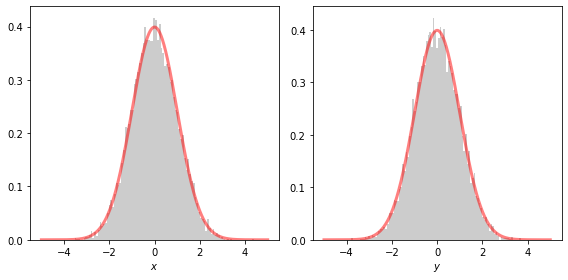

In [20]:
# Box Muller method
import numpy as np
import matplotlib.pylab as plt


def sample_gaussian(S):
    """
    Sample standard Gaussian distribution using Box-Muller 
    """
    u, v = np.random.random(size=(2, int(S)))
    r = np.sqrt(-2*np.log(u))
    phi = 2 * np.pi * v
    
    return r * np.cos(phi), r * np.sin(phi)


S = 1e4
x, y = sample_gaussian(S)
t = np.linspace(-1., 1., 1000) * 5
p = np.exp(-0.5*t**2) / np.sqrt(2*np.pi)

kw = dict(bins=100, color='k', alpha=0.2, density=True)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), 
                       subplot_kw=dict(yticks=[0., 0.1, 0.2, 0.3, 0.4]))
ax[0].hist(x, **kw)
ax[0].set_xlabel(r'$x$')
ax[1].hist(y, **kw)
ax[1].set_xlabel(r'$y$')
for a in ax:
    a.plot(t, p, lw=3, alpha=0.5, color='r')
fig.tight_layout()

### Multivariate Gaussians

By using a variable transformation, we can use samples from univariate standard Gaussians to generate samples from general multivariate Gaussians: 

$$
x \sim \mathcal N(\mu, \Sigma) = \frac{1}{|2\pi\Sigma|^{1/2}} \exp\left\{-\frac{1}{2} (x-\mu)^T\Sigma^{-1} (x-\mu) \right\}
$$

where the covariance matrix $\Sigma$ is positive definite and therefore has a Cholesky decomposition $\Sigma=LL^T$ with a lower triangular matrix $L$.  

Now consider $y\sim \mathcal N(0, I)$ (these can be generated with the Box-Muller method) and the linear transformation

$$
x = \mu + L y\,\,\, \Rightarrow \,\,\, y = L^{-1} (x-\mu).
$$

The Jacobian of this transform is $L$ with determinant $|L| = \sqrt{|\Sigma|}$. Thus the distribution of $x$ is

$$
p_x(x) = (2\pi)^{-D/2} \exp\left\{-\frac{1}{2} (x-\mu)^T (L^{-1})^T L^{-1} (x-\mu) \right\} / \sqrt{|\Sigma|} = \mathcal N(\mu, \Sigma)
$$

since $(L^{-1})^T L^{-1} = (L^T)^{-1} L^{-1} = (LL^T)^{-1} = \Sigma^{-1}$. 


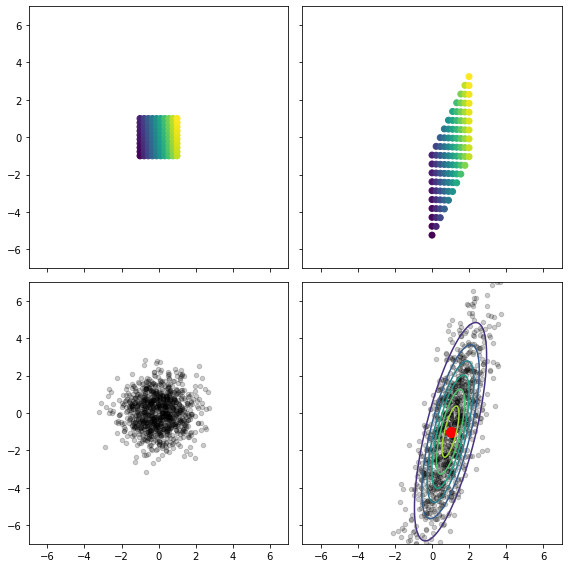

In [21]:
# 2d example
import numpy as np
import matplotlib.pylab as plt

# parameters of a 2d Gaussian
sigma1, sigma2, rho = 1., 3., 0.7
Sigma = np.array([[sigma1**2, rho*sigma1*sigma2],
                [rho*sigma1*sigma2, sigma2**2]])
L = np.linalg.cholesky(Sigma)
mu = np.array([1., -1.])

# transformation of the grid
grid1 = np.reshape(np.mgrid[-1.:1.:10j,-1:+1.:10j], (2, -1)).T
limits = (-5., 5.)
c = plt.cm.viridis(np.linspace(0., 1., len(grid1)))

# sampling using a linear transformation
S = int(1e3)
x = np.random.standard_normal((S, 2))
y = x.dot(L.T) + mu

# evaluate 2d Gaussian on a grid
axes = [np.linspace(yy.min(), yy.max(), 100) for yy in y.T]
grid = np.reshape(np.meshgrid(*axes), (2, -1)).T
prob = np.exp(-0.5 * np.sum(np.square((grid-mu).dot(np.linalg.inv(L).T)), 1))
prob = prob.reshape(len(axes[0]), len(axes[1]))

# show initial distributions and its transformed version
kw = dict(s=20, color='k', alpha=0.2)
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex='all', sharey='all')
ax[0, 0].scatter(*grid1.T, c=c)
ax[0, 1].scatter(*(grid1.dot(L.T) + mu).T, c=c)
ax[1, 0].scatter(*x.T, **kw)
ax[1, 1].scatter(*y.T, **kw)
ax[1, 1].scatter(*mu, s=100, color='r')
ax[1, 1].contour(axes[0], axes[1], prob)
xmax = 7
for a in ax.flat:
    a.set_xlim(-xmax, xmax)
    a.set_ylim(-xmax, xmax)
fig.tight_layout()

# Lecture 3: Rejection and Importance Sampling

## Outline

* More direct sampling methods
* Rejection sampling
* Importance sampling

## Recap

* Our goal is to compute $\mathbb E_p[f]$ for some probabilistic model $p$. Most inference tasks can be reduced to such sums or integrals

* Monte Carlo approximation: $\mathbb E_p[f] \approx \hat f_S = \frac{1}{S} \sum_{s=1}^S f(x^{(s)})$ where $x^{(s)} \sim p(x)$. 

* Properties: unbiased ($\mathbb E[\hat f_S] = \mathbb E_p[f]$) and $\text{var}[\hat f_S] = \frac{\text{var}[f]}{S}$

* Monte Carlo errors shrink with $1/\sqrt{S}$, no dependence on dimension $D$, but factor $\text{var}[f]$ can depend on $D$ in an unfavorable fashion (hypersphere example)

* Correct sampling means that approximate probability $\hat p_S(x) = \frac{1}{S} \sum_s \delta(x - x^{(s)}) \to p(x)$ for $S\to\infty$ ("histogram over samples approximates true model"). But how to sample?

* Uniformly distributed samples can be generated with pseudo-random number generators such as the linear congruential generator. These have their own subtleties...

* Direct sampling is possible via variable transformation methods that utilize the transformation rule: $p_y(y) = p_x(h^{-1}(y)) / |\nabla h(h^{-1}(y))|$

* Inversion method: $h(x) = P(x) = \int^x p(x')\, dx$ (cumulative distribution function)

* Some examples of transformation methods: Box-Muller $(x, y) = r (\cos\varphi, \sin\varphi)$, multivariate Gaussians 

### Sampling uniformly from the hypersphere

The $D$-dimensional standard Gaussian distribution $\mathcal N(0, I)$ can be used to sample from the [hypersphere](https://en.wikipedia.org/wiki/N-sphere) in $D$-dimensional space $\mathbb S^{D-1} = \{ x \in \mathbb R^D : \|x\| = 1\}$. To see this, consider

$$
\mathcal N(0, I) = (2\pi)^{-D/2} \exp\bigl\{-\|x\|^2/2 \bigr\} \to (2\pi)^{-D/2}\, r^{D-1} e^{-r^2/2} \mathbb 1(\|x\| = 1) 
$$

That is, the $D$-dimensional standard Gaussian distribution is spherically symmetric and therefore

$$
x/\|x\| \sim \mathcal U(\mathbb S^{D-1})\,\,\, \text{where}\,\,\, x \sim \mathcal N(0, I)
$$

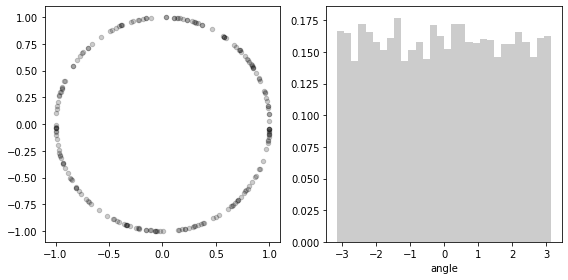

In [22]:
# sampling from the hypersphere
import numpy as np
import matplotlib.pylab as plt

def sample_sphere(S, D=2):
    """
    S : number of samples
    D : dimension of embedding space
    """
    x = np.random.standard_normal((D, S))
    return (x/np.linalg.norm(x, axis=0)).T

x = sample_sphere(10000)
angle = np.arctan2(x[:,1], x[:,0])
kw = dict(color='k', alpha=0.2, s=20)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(*x[:200].T, **kw)
ax[1].hist(angle, bins=30, density=True, alpha=0.2, color='k')
ax[1].set_xlabel('angle')
fig.tight_layout()

### Sampling from the unit ball

Using samples from the $(D-1)$-sphere we can also easily sample from the [$D$-dimensional unit ball](https://en.wikipedia.org/wiki/Ball_(mathematics)) $\mathbb B^D = \{x\in\mathbb R : \|x\| \le 1\}$. Every element in $\mathbb B^D$ can be decomposed into

$$
x = r\, u \in \mathbb B^D\,\,\,\text{where}\,\,\, u\in\mathbb S^{D-1},\, r\in[0, 1]
$$

The distribution of $r$ follows from the surface area of $\mathbb S^{D-1}$ which scales with $r^{D-1}$, therefore:

$$
p(r, u) = D\, r^{D-1}\, \mathbb 1(\|u\| = 1)
$$

The cdf of the radial component is $r^D$ and we obtain the following sampling rule:

1. $u^{(s)}=x^{(s)}/\|x^{(s)}\|$ where $x^{(s)} \sim \mathcal N(0, I_D)$

2. $r^{(s)} = (v^{(s)})^{1/D}$ where $v^{(s)} \sim \mathcal U(0, 1)$

3. then $r^{(s)} u^{(s)} \sim \mathcal U(\mathbb B^D)$

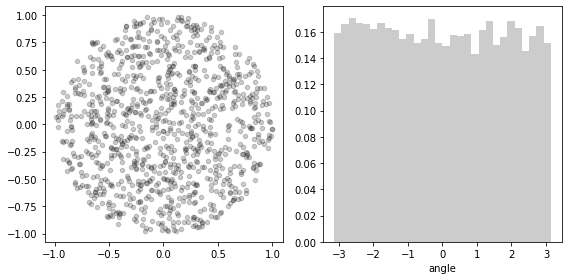

In [23]:
# sampling from the unit ball
import numpy as np
import matplotlib.pylab as plt

def sample_ball(S, D=2):
    """
    Sampling from the D-ball
    S : number of samples
    D : dimension of embedding space
    """
    # sample from hypersphere
    x = np.random.standard_normal((D, int(S)))
    u = x / np.linalg.norm(x, axis=0)
    # sample radius
    r = np.random.random(int(S))**(1/D)
    return (u*r).T
                                                                            
x = sample_ball(10000)
angle = np.arctan2(x[:,1], x[:,0])
kw = dict(color='k', alpha=0.2, s=20)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(*x[:1000].T, **kw)
ax[1].hist(angle, bins=30, density=True, alpha=0.2, color='k')
ax[1].set_xlabel('angle')
fig.tight_layout()

### Sampling from a radially symmetric distribution

It is straightforward to generalize sampling from a unit ball to any spherically symmetric distribution. A spherically symmetric distribution over $D$ continuous variables has the form:

$$
    p(x) \propto f(\|x\|)
$$

where $f(r)$ is defined for $r\in\mathbb R_+$. A convenient parameterization are spherical coordinates, resulting in the distribution

$$
p(x) \to r^{D-1}f(r)\, \mathcal{U}(\mathbb S^{D-1})
$$

We know how to generate uniform samples from $\mathcal U(\mathbb S^{D-1})$. The remaining problem is to sample from

$$
p(r) \propto r^{D-1} f(r),\,\,\, r\ge 0
$$

So we have reduced a $D$-dimensional sampling problem to a one-dimensional problem.

### Sampling from an elliptically symmetric distribution

A similar technique can be used to generalize sampling from spherically symmetric distributions to elliptically symmetric distributions of the form

$$
p(x) \propto f\bigl((x-b)^T\!\!A(x-b)\bigr)
$$

where $x, b \in \mathbb R^D$ and $A\in\mathbb R^{D\times D}$ is positive definite; $f(r)\ge 0$ is an (unnormalized) radial pdf defined for $r\in\mathbb R_+$.  

## Using known relations between probability distributions for sampling

The [Erlang distribution](https://en.wikipedia.org/wiki/Erlang_distribution), a special version of the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), has the functional form

\begin{equation}\label{eq:erlang}
    p(x|k, \lambda) = \frac{\lambda^k}{\Gamma(k)} x^{k - 1} e^{-\lambda x}, \, k \in \mathbb N, \, k> 0,\, \lambda > 0
\end{equation}

We can use exponentially distributed random variables $z_i \sim \lambda e^{-\lambda z_i}, i=1, \ldots, k$ to produce an Erlang variate. Define $z_i = x y_i$ with $y_i\in[0, 1]$ for $1 \le i \le k-1$ and $z_k = x \bigl(1-\sum_{i=1}^{k-1} y_i\bigr)$, then $x = \sum_i z_i$. The Jacobian of the parameter transform is

$$
\frac{\partial (z_1, \ldots, z_k)}{\partial (x, y_1, \ldots, y_{k-1})} = 
\begin{pmatrix}
y_1 & x & 0 & \cdots & 0 \\
y_2 & 0 & x & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
y_{k-1} & 0 & 0 & \cdots & x \\
1- \sum_i y_{i} & -x & -x & \cdots & -x \\
\end{pmatrix}
$$

with determinant

$$
\left|\frac{\partial (z_1, \ldots, z_k)}{\partial (x, y_1, \ldots, y_{k-1})}\right| \propto x^{k-1} 
$$

Therefore:

$$
x \sim x^{k-1} e^{-\lambda x}
$$

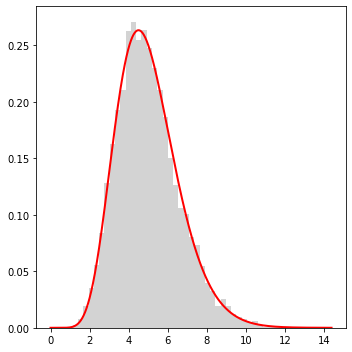

In [24]:
# sampling from Erlang
import numpy as np
import matplotlib.pylab as plt

from scipy.special import gammaln


def sample_erlang(S, k=1, beta=1.):
    
    u = np.random.random((int(S), k))
    z = - np.log(u) / beta
    x = z.sum(1)

    return x


k = 10
beta = 2.
S = 1e4

x = sample_erlang(S, k=k, beta=beta)

t = np.linspace(0., x.max(), 1000)
p = k * np.log(beta) + (k-1) * np.log(t+1e-100) - beta * t - gammaln(k)
p = np.exp(p)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(t, p, color='r', lw=2)
ax.hist(x, bins=50, color='lightgrey', density=True)
fig.tight_layout() 

There are many more relationships between standard univariate probability distributions that can be exploited for sampling (an interactive version of the following Figure can be found at [Leemis & Mc Queston: Univariate Distribution RelationShips](http://www.math.wm.edu/~leemis/chart/UDR/UDR.html)):

![Relationships between pdfs](images/UnivariateDistributionRelationships.png "Relationshipts between univariate pdfs")

## Further reading

Donald Knuth: [The Art of Computer Programming, Vol. 2, Chap. 1](https://en.wikipedia.org/wiki/The_Art_of_Computer_Programming)

Luc Devroye: [Non-Uniform Random Variate Generation](https://link.springer.com/book/10.1007/978-1-4613-8643-8)

# Rejection sampling

Direct sampling methods are specifically designed for particular target distributions. For complex probabilistic models such as the Ising model, it will not be possible to use these methods. We will now discuss methods that can be applied to more general probabilistic models.   

[*Rejection sampling*](https://en.wikipedia.org/wiki/Rejection_sampling) is an early sampling approach that has been developed by von Neumann. The idea is to use a helper distribution $q$ from which we can sample easily in order to sample from a more complicated model $p$. To be a valid proposal distribution, $q$ must satisfy

\begin{equation}\label{eq:rejection_proposal}
    p(x) \le M q(x)
\end{equation}

for a constant $M$ which implies $M\ge 1$, since $p$ and $q$ are normalized pdfs. Moreover, the support of $p$ should be contained in the support of the proposal distribution $q$. Let's define the ratio 

\begin{equation}\label{eq:rejection_accprob}
r(x) := \frac{p(x)}{M q(x)}
\end{equation}

which is smaller than or equal to 1 for all $x$ with $q(x)>0$, otherwise we set $r(x) = 1$. 

## Algorithm: Rejection sampling

The algorithm produces random samples $x^{(s)}$ by iterating over the following steps until the desired number of samples $S$ has been generated: 

1. Draw $x \sim q(x)$

2. Draw $u \sim \mathcal U(0, 1)$

3. $r \gets \frac{p(x)}{Mq(x)}$

4. If $u < r$, then 

    * $x^{(s)} \gets x$
    * $s \gets s+1$. 

5. If $s < S$, go to 1. 

### Example: Sampling a Gaussian with a Cauchy proposal

The standard Gaussian distribution is

$$
p(x) = \frac{1}{\sqrt{2\pi}}\, e^{-x^2/2}
$$

and the Cauchy distribution

$$
q(x) = \frac{1}{\pi} \frac{1}{1 + x^2}\, .
$$

The Cauchy distribution can be sampled with the inversion method: $x^{(s)} = -\tan(\pi u^{(s)}), \, u^{(s)} \sim \mathcal U(0, 1)$ (see table above). 

To show that the Cauchy distribution is a valid proposal distribution, we first have to bound the ratio

$$
f(x) = \frac{p(x)}{q(x)} = \sqrt{\frac{\pi}{2}}\, (1 + x^2)\, e^{-x^2/2}\, .
$$

The first derivative is 
$$
f'(x)  = \sqrt{\frac{\pi}{2}}\, x\, (1 - x^2)\, e^{-x^2/2}
$$
with zeros $x=-1, 0, 1$. The second derivative $f''(x) = \sqrt{\frac{\pi}{2}}\, (x^4 - 4x^2 +1)\, e^{-x^2/2}$ is positive at $x=0$ and negative at $x=\pm 1$. Therefore, $x=\pm 1$ are the locations of the maxima of $f$, and the upper bound is $M := f(1) = \sqrt{2\pi/e} \approx 1.52$. 

In [25]:
import numpy as np
import matplotlib.pylab as plt

def sample_cauchy(S):
    u = np.random.random(int(S))
    return -np.tan(np.pi * u)


def calc_ratio(t):
    return 0.5 * (1 + t**2) * np.exp(-0.5 * t**2) * np.sqrt(np.e)
    

S = int(1e3)
M = np.sqrt(2*np.pi/np.e)
y = sample_cauchy(M*S)
r = calc_ratio(y)
u = np.random.random(y.shape)
Mq = M / (1 + y**2) / np.pi

t = np.linspace(-1., 1., 1000) * 5
q = 1 / (1 + t**2) / np.pi
p = np.exp(-0.5 * t**2) / np.sqrt(2*np.pi)
M

1.520346901066281

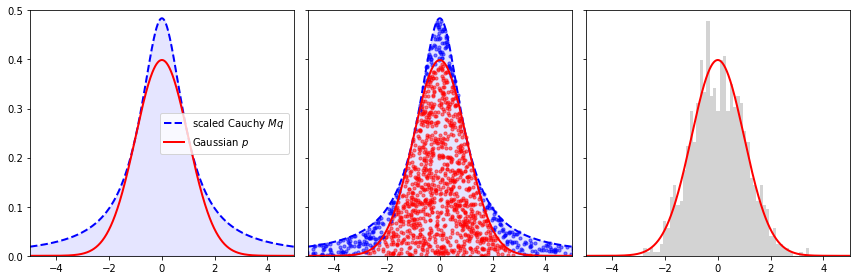

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, 
                       sharey=True)
#
ax[0].fill_between(t, t*0., M*q, color='b', alpha=0.1)
ax[0].plot(t, M*q, color='b', lw=2, ls='--', label=r'scaled Cauchy $Mq$')
ax[0].plot(t, p, color='r', lw=2, ls='-', label=r'Gaussian $p$')
ax[0].legend(loc=5)
#
ax[1].fill_between(t, t*0., M*q, color='b', alpha=0.1)
ax[1].scatter(y[u<r], (Mq*u)[u<r], color='r', s=10, alpha=0.5)
ax[1].scatter(y[u>=r], (Mq*u)[u>=r], color='b', s=10, alpha=0.5)
ax[1].plot(t, M*q, color='b', lw=2, ls='--', label=r'scaled Cauchy $Mq$')
ax[1].plot(t, p, color='r', lw=2, ls='-', label=r'Gaussian $p$')
#
ax[2].hist(y[u<r], bins=50, color='lightgrey', density=True)
ax[2].plot(t, p, color='r', lw=2, ls='-')
#
ax[2].set_xlim(-5., 5)
ax[2].set_ylim(0., 0.5)

fig.tight_layout()

## Why does rejection sampling work?

Let's formalize the rejection sampling algorithm. To this end, we introduce a binary random variable $a\in\{0, 1\}$ indicating if a proposal $x \sim q(x)$ has been accepted or not. The probability of being accepted, $a=1$, or rejected, $a=0$, is

$$
p(a=1\mid{}x) = r(x), \,\,\ p(a=0\mid{}x) = 1 - r(x)\, .
$$

This means that $a$ is a [Bernoulli variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

$$
p(a\mid{}x) = \bigl[r(x)\bigr]^a \bigl[1-r(x)\bigr]^{1-a}, \,\,\, a\in\{0, 1\}\, .
$$

The joint distribution of $x$ and $a$ is

$$
p(a, x) = p(a\mid{}x)\, q(x)
$$

since $x\sim q$. The accepted samples are those for which $a=1$. These samples follow the *conditional* distribution $p(x\mid{}a=1)$. That is 

$$
x^{(s)} \sim p(x\mid{}a=1)\, .
$$

It is straight forward to compute this distribution. We have $p(x\mid{}a=1) = p(x, a=1)\, /\, p(a=1)$. We need to compute the marginal probability $p(a=1)$:

\begin{equation}\label{eq:rs-acceptance}
p(a=1) = \int p(x, a=1)\, dx = \int q(x)\, r(x)\, dx = \int q(x)\, \frac{p(x)}{Mq(x)}\, dx = \frac{1}{M}
\end{equation}

since $p$ is normalized. Equation (\ref{eq:rs-acceptance}) tells us that the average probability to propose an acceptable sample is $M^{-1}$. We can now compute the desired conditional distribution $p(x\mid{}a=1)$: 

$$
p(x\mid{}a=1) = \frac{p(x, a=1)}{p(a=1)} = M q(x)\, r(x) = M q(x)\, \frac{p(x)}{M q(x)} = p(x)\, .
$$


### Waiting time before acceptance

We can also compute the number of attempts it needs to generate an acceptable proposal. Let's call this number $T$. The probability that a proposal is accepted after $T-1$ unsuccessful trials is 

$$
\Pr(T) = [p(a=0)]^{T-1} p(a=1) = [1-M^{-1}]^{T-1} M^{-1}, \,\,\, T\in \{1, 2, 3, \ldots \} 
$$

which is the probability that the first $T-1$ samples are rejected ($a^{(t)}=0, \, t<T$) and the last sample is accepted $a^{(T)}=1$. This distribution is a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution) and normalized since

$$
\sum_{T\ge 1} \Pr(T) = \sum_{T\ge 1} [1-M^{-1}]^{T-1}\, M^{-1} = M^{-1} \sum_{T\ge 0} [1-M^{-1}]^{T} = \frac{M^{-1}}{1 - (1 - M^{-1})} = 1
$$

using the summation rules for [geometric progressions](https://en.wikipedia.org/wiki/Geometric_progression) and [geometric series](https://en.wikipedia.org/wiki/Geometric_series). 

The expected time one has to wait until an acceptable sample is proposed is

$$
\mathbb E[T] = \sum_{T\ge 1} T\, \Pr(T) = M^{-1} \sum_{T\ge 1} T\, [1-M^{-1}]^{T-1} = 1 + M^{-1} \sum_{T \ge 0} T \, [1-M^{-1}]^T\, .
$$

To compute the last series, let us rewrite it as $\sum_{T\ge 0} T e^{-\lambda T}$ where $\lambda = - \log(1-M^{-1}) > 0$:

$$
\sum_{T\ge 0} T e^{-\lambda T} = - \sum_{T\ge 0} \frac{d}{d\lambda} e^{-\lambda T} = - \frac{d}{d\lambda} \sum_{T\ge 0} e^{-\lambda T} = - \frac{d}{d\lambda} \frac{1}{1 - e^{-\lambda}} = \frac{e^{-\lambda}}{(1 - e^{-\lambda})^2}\, .
$$

By substituting $e^{-\lambda} = 1-M^{-1}$ we obtain

$$
\mathbb E[T] = 1 + M^{-1} \frac{1-M^{-1}}{(1 -(1-M^{-1}))^2} = 1 + M^{-1} \frac{1-M^{-1}}{M^{-2}} = M\, .
$$

The larger $M$, the longer is the average time that we have to wait until a sample is accepted. Therefore, we should try to design an envelope $Mq(x)>p(x)$ that is as tight as possible. 

Let us modify the above code for sampling a Gaussian using Cauchy proposals by allowing $M$ to be greater than the tightest upper bound $\sqrt{2\pi/e}$ and investigate the effect on the waiting time: 

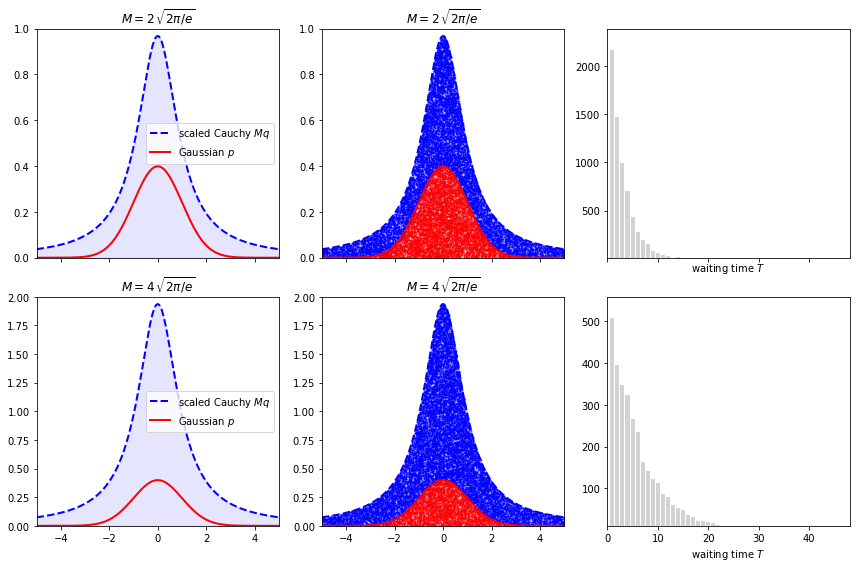

In [27]:
# tightest bound
M_opt = (2*np.pi/np.e)**(1/2)

def calc_ratio(t, M=M_opt):
    return 0.5 * (1 + t**2) * np.exp(-0.5 * t**2) * np.sqrt(np.e) * (M_opt/M)

# evaluate Gaussian and Cauchy distribution
t = np.linspace(-1., 1., 1000) * 5
q = 1 / (1 + t**2) / np.pi
p = np.exp(-0.5 * t**2) / np.sqrt(2*np.pi)

# rejection sampling
S = int(2e4)

fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex='col')

# M = factor * M_opt
for i, factor in enumerate([2, 4]):

    M = factor * M_opt
    y = sample_cauchy(S)
    r = calc_ratio(y, M)
    u = np.random.random(y.shape)
    Mq = M / (1 + y**2) / np.pi
 
    # waiting times
    T = np.diff(np.nonzero(u<r)[0])

    ax[i,0].set_title(r'$M={0}\, \sqrt{{2\pi/e}}$'.format(factor))
    ax[i,0].fill_between(t, t*0., M*q, color='b', alpha=0.1)
    ax[i,0].plot(t, M*q, color='b', lw=2, ls='--', label=r'scaled Cauchy $Mq$')
    ax[i,0].plot(t, p, color='r', lw=2, ls='-', label=r'Gaussian $p$')
    ax[i,0].legend()
    #
    ax[i,1].set_title(r'$M={0}\, \sqrt{{2\pi/e}}$'.format(factor))
    ax[i,1].fill_between(t, t*0., M*q, color='b', alpha=0.1)
    ax[i,1].scatter(y[u<r], (Mq*u)[u<r], color='r', s=1, alpha=0.5)
    ax[i,1].scatter(y[u>=r], (Mq*u)[u>=r], color='b', s=1, alpha=0.5)
    ax[i,1].plot(t, M*q, color='b', lw=2, ls='--', label=r'scaled Cauchy $Mq$')
    ax[i,1].plot(t, p, color='r', lw=2, ls='-', label=r'Gaussian $p$')
    #
    times, counts = np.unique(T, return_counts=True)
    ax[i,2].bar(times, counts, color='lightgrey')
    ax[i,2].set_xlim(0, times.max()+1)
    ax[i,2].set_ylim(10, counts.max()*1.1)
    ax[i,2].set_xlabel(r'waiting time $T$')

    for a in ax[i,:2]:
        a.set_xlim(-5, 5.)
        a.set_ylim(0., factor/2)
        
    for a in ax[:,2]:
        a.set_xlim(0, times.max()+1)
fig.tight_layout()

### Geometric interpretation

A geometric interpretation of rejection sampling is that we generate points $(x,y)$ under the graph of $Mq(x)$ in the following fashion: The $x$ coordinate is drawn from $q$, and the $y$ coordinate from a uniform distribution $y=M q(x) u$ where $u\sim \mathcal U(0, 1)$:

$$
(x, y) \sim q(x)\, \mathbb 1\bigl(y < Mq(x)\bigr)
$$

$(x,y)$ is accepted if $y < p(x)$ otherwise it is rejected. Therefore, the area under $Mq$ can be separated into an *acceptance region* and a *rejection region*. The value of $M$ determines the relative size of the rejection and acceptance regions. 

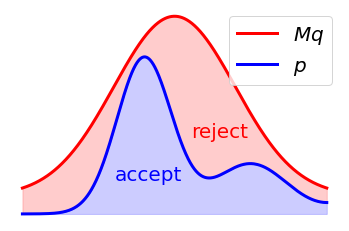

In [28]:
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import gaussian_filter

t = np.linspace(-1., 1., 1000) * 10
mu = np.array([-2,  5. ])
sigma = np.array([90., 120. ])
w = np.array([0.7, 0.3])

p = 0.
for k in range(len(mu)):
    y = t * 0.
    y[np.argmin(np.fabs(mu[k]-t))] = 1.
    p += gaussian_filter(y, sigma=sigma[k]) * w[k]
p /= p.sum()

q = np.exp(-0.5 * t**2 / 16) + 0.1
q /= q.sum()

M = np.max(p/q) * 1.1

fs = 20
fig, ax = plt.subplots(subplot_kw=dict(xticks=[], yticks=[]))
ax.fill_between(t, p, q*M, color='r', alpha=0.2)
ax.plot(t, q*M, color='r', lw=3, label=r'$Mq$')
ax.fill_between(t, p*0, p, color='b', alpha=0.2)
ax.plot(t, p, color='b', lw=3, label=r'$p$')
ax.annotate('accept', (0.32, 0.2), xycoords='axes fraction', color='b', fontsize=fs)
ax.annotate('reject', (0.55, 0.4), xycoords='axes fraction', color='r', fontsize=fs)
ax.legend(fontsize=fs)
ax.set_frame_on(False)

There are multiple factors that influence $M$. The size of the support of $q$ has a direct impact on $M$: The larger the support of $q$, the larger we have to choose $M$ to still satisfy the condition $p(x) \le Mq(x)$, because the probability mass of the proposal distribution is distributed over a larger region and the density $q$ is scaled down. The tightest $M$ can be found by maximizing the ratio $p(x)/q(x)$ over the sample space. In general, this will be a hard optimization problem. But even if we find the tightest value of $M$, the size of the rejection region will grow exponentially with dimension $D$.   

### Rejection sampling scales badly with dimension

Finding tight bounds in high dimensions is very difficult. Moreover, the volume of the rejection region will scale exponentially with dimension. For example, if we sample a $D$ dimensional Gaussian by using $D$ Cauchy variates, than each dimension contributes a factor of $\sqrt{2\pi/e} \approx 1.5$ such that the overall $M$ scales as $1.5^D$. As a consequence, the waiting time will scale exponentially with dimension and using rejection sampling will become increasingly inefficient as the size of our probabilistic model grows. 

### Unnormalized target and proposal distribution

Often, it is not possible to normalize a probabilistic model. So we only know $p^*(x)$ and $q^*(x)$ with

\begin{eqnarray*}
p(x) &=& \frac{p^*(x)}{Z_p}\,\,\,\text{with}\,\,\, Z_p = \int_{\mathcal X} p^*(x)\, dx < \infty\\ 
q(x) &=& \frac{q^*(x)}{Z_q}\,\,\,\text{with}\,\,\, Z_q = \int_{\mathcal X} q^*(x)\, dx < \infty\, . 
\end{eqnarray*}

The condition that has to be satisfied is now

$$
p^*(x) \le M q^*(x)\,\,\, \Rightarrow M \ge Z_p/Z_q\, .
$$

In analogy to Eq. (\ref{eq:rejection_accprob}), the acceptance probability changes to

$$
r(x) = \frac{p^*(x)}{M q^*(x)} \le 1
$$

Otherwise the sampling procedure and the proof of its validity work in the same fashion:

$$
p(x, a=1) = q(x)\, r(x) = \frac{q^*(x)}{Z_q} \frac{p^*(x)}{M q^*(x)} = \frac{p^*(x)}{MZ_q} 
$$

and

$$
p(a=1) = \int_{\mathcal X} p(x, a=1)\, dx = \frac{Z_p}{MZ_q}\, .
$$

So
$$
x^{(s)} \sim \frac{p(x, a=1)}{p(a=1)} = \frac{p^*(x)}{MZ_q}\, \frac{MZ_q}{Z_p} = \frac{p^*(x)}{Z_p} = p(x)\, .
$$

# Importance sampling

Rejection sampling becomes very inefficient as soon as no tight bound can be found and most samples are rejected. We saw a drastic version of this problem in our attempt to estimate the volume of the $D$-ball by accepting or rejecting samples from a hypercube: The acceptance probability is the ratio of the volumes of the $D$-ball and the $D$-cube and drops to zero with a rate that is exponential in $D$. 

[*Importance sampling*](https://en.wikipedia.org/wiki/Importance_sampling) tries to overcome some of these problems by using a strategy that does not reject samples, but weighs them thereby avoiding to "waste" any samples. Otherwise the idea of importance sampling is very similar to rejection sampling: A helper distribution $q$ (from which we can sample easily) is used to generate samples that are now reweighted rather than accepted or rejected. The weights are chosen such that samples from $q$ can be used to compute expectations under the target model $p$.

To derive importance sampling, let us look at the expectation 

$$
\mathbb E_p[f] = \int_{\mathcal X} f(x)\, p(x)\, dx = \int_{\mathcal X} f(x)\, \frac{p(x)}{q(x)}\, q(x)\, dx = \int_{\mathcal X} f(x)\, w(x)\, q(x)\, dx = \mathbb E_q[wf]\, .
$$

So expectations with respect to $p$ can be expressed as expectations with respect to $q$, if samples $x$ are weighted with $w(x) = \frac{p(x)}{q(x)}$. The only requirement is

$$
q(x) = 0\,\,\, \Rightarrow\,\,\, f(x)p(x) = 0
$$

which is easier to satisfy than the requirements for rejection sampling.

## Algorithm: Importance sampling

The algorithm produces random samples $x^{(s)}$ and (importance) weights $w^{(s)}$: 

1. Sample $x^{(s)} \sim q(x)$ for $s=1,\ldots, S$.

2. Compute weights $w^{(s)} = \frac{p(x^{(s)})}{q(x^{(s)})}$

Expectation values are then approximated by

\begin{equation}\label{eq:IS}
\mathbb E_p[f] \approx \hat f_{\text{IS}} := \frac{1}{S} \sum_{s=1}^S w^{(s)} \, f(x^{(s)})
\end{equation}

The right hand side can be interpreted as the expectation of $f$ under the approximate density

\begin{equation}\label{eq:is-approximation}
\hat p_S(x) = \frac{1}{S} \sum_{s=1}^S w^{(s)} \delta\bigl(x - x^{(s)}\bigr)\, .
\end{equation}

This is a generalization of the approximate density introduced earlier in Eq. (\ref{eq:approximate_pdf}). 

Let us again use a Gaussian target and a Cauchy proposal to illustrate the sampling algorithm:

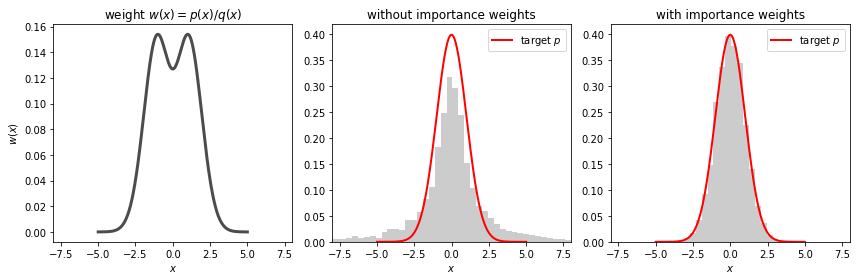

In [29]:
import numpy as np
import matplotlib.pylab as plt


def sample_cauchy(S, lower=-10, upper=10):
    u = np.random.random(2*int(S))
    x = -np.tan(np.pi * u)
    m = (x >= lower) & (x <= upper)
    return x[m][:int(S)]


def pdf_gaussian(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)


def pdf_cauchy(x):
    return np.pi / (1 + x**2)


S = int(5e3)
t = np.linspace(-1., 1., 1000) * 5
p = pdf_gaussian(t)
q = pdf_cauchy(t)

x = sample_cauchy(S, -20, 20)
w = pdf_gaussian(x) / pdf_cauchy(x)
kw = dict(xlim = (-8, 8), xlabel = r'$x$')
kw_hist = dict(bins=100, density=True, color='k', alpha=0.2)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, subplot_kw=kw)
#
ax[0].set_title(r'weight $w(x) = p(x) / q(x)$')
ax[0].plot(t, p / q, color='k', lw=3, alpha=0.7)
ax[0].set_ylabel(r'$w(x)$')
#
ax[1].set_title('without importance weights')
ax[1].hist(x, **kw_hist)
#
ax[2].set_title('with importance weights')
ax[2].hist(x, weights=w/S, **kw_hist)
#
for a in ax[1:]:
    a.plot(t, p, color='r', lw=2, label=r'target $p$')
    a.legend()
#
fig.tight_layout()

## Properties of importance sampling

The importance sampling estimator (Eq. \ref{eq:IS}) is unbiased: The $S$ samples follow the joint distribution $q_S(x^{(1)}, \ldots, x^{(S)}) = \prod_s q(x^{(s)})$, and the expectation of the importance sampling estimator is

$$
\mathbb E_{q_S}[\hat f_{\text{IS}}] 
= \frac{1}{S} \mathbb E_{q_S}\biggl[\sum_s f(x^{(s)}) p(x^{(s)})/q(x^{(s)})\biggr] 
= \frac{1}{S} \sum_s \underbrace{\mathbb E_{q_S}\biggl[f(x^{(s)}) p(x^{(s)})/q(x^{(s)})\biggr]}_{\mathbb E_p[f]} 
= \mathbb E_p[f]\, .
$$

The law of large numbers guarantees that $\hat f_{\text{IS}} \to \mathbb E_p[f]$ for $S\to\infty$. 

Since the importance sampling (IS) estimator $\hat f_{\text{IS}}$ is simply the Monte Carlo estimator for $w(x)f(x)$ and sampling distribution $q$, also the variance is readily available from Eq. (\ref{eq:MCvariance}): 

$$
\text{var}[\hat f_{\text{IS}}] = \frac{1}{S} \text{var}_q[wf] \, . 
$$

Using $\text{var}[f] = \mathbb E[f^2] - (\mathbb E[f])^2$, we obtain

$$
\text{var}_q[wf] = \underbrace{\mathbb E_q[(wf)^2]}_{\mathbb E_p[wf^2]} - \bigl(\underbrace{\mathbb E_q[wf]}_{\mathbb E_p[f]}\bigr)^2 = \mathbb E_p[wf^2] - \bigl( \mathbb E_p[f] \bigr)^2
$$

\begin{equation}\label{eq:ISvariance}
\text{var}[\hat f_{\text{IS}}] = \frac{1}{S} \biggl( \mathbb E_p[wf^2] - \bigl( \mathbb E_p[f] \bigr)^2 \biggr)\, . 
\end{equation}

Like the error of the standard Monte Carlo approximation, the error of the IS estimator shrinks with $1/\sqrt{S}$. We can also minimize the variance of the IS estimator as a functional of the proposal distribution (subject to the constraint $\int q(x)\, dx = 1$), which can be achieved by minimizing the Lagrangian $\mathbb E_p[p/q\, f^2] + \lambda (1-\int q(x) dx)$ resulting in the optimal IS proposal:

$$
q_{\text{opt}}(x) \propto |f(x)|\, p(x)\, .
$$

This estimator achieves minimum variance
$$
\left(\mathbb E_p[|f|] \right)^2 - \left(E_p[f] \right)^2
$$

which can approach zero if $f(x) \ge 0$. However, this result is mostly of theoretical interest. 

## Comparison between classical Monte Carlo and importance sampling

* Importance sampling should be used when we cannot sample efficiently from the target model $p$

* A reason to use importance sampling can be to reduce the variance over the classical Monte Carlo estimator

* Importance sampling can be used if rejection sampling is not applicable (because we cannot find an upper bound for the ratio $p(x)/q(x)$)

## Self-normalized importance sampling

In case of complex, high-dimensional probabilistic models the normalizing constants are often missing:

$$
p(x) = \frac{p^*(x)}{Z_p}, \, q(x) = \frac{q^*(x)}{Z_q}
$$

with $Z_p = \int p^*(x)\, dx$ and $Z_q = \int q^*(x)\, dx$.

In this case the importance weights 

$$
w(x) = \frac{p(x)}{q(x)} = \frac{Z_q}{Z_p} \frac{p^*(x)}{q^*(x)}
$$

are not readily available, because the ratio of normalizing constants $Z_q/Z_p$ is unknown. 

However, we can use importance sampling to estimate this unknown ratio:

$$
\frac{Z_p}{Z_q} = \frac{\int p^*(x)\, dx}{Z_q} = \frac{\int \frac{p^*(x)}{q^*(x)}\, q^*(x)\, dx}{Z_q} = \int \frac{p^*(x)}{q^*(x)} \, q(x)\, dx = \mathbb E_q[p^*/q^*] 
$$

The IS estimator for the ratio of normalizing constants is

\begin{equation}\label{eq:ISratio}
(\widehat{Z_p/Z_q})_{\text{IS}} = \frac{1}{S} \sum_{s=1}^S \frac{p^*(x^{(s)})}{q^*(x^{(s)})} \, .
\end{equation}

Plugging this estimator into standard IS estimator (Eq. \ref{eq:IS}) yields the *self-normalized* importance sampling (NIS) estimator

\begin{equation}\label{eq:ISselfnormalized}
\hat f_{\text{NIS}} = \frac{\sum_{s=1}^S \frac{p^*(x^{(s)})}{q^*(x^{(s)})}\, f(x^{(s)})}{ \sum_{s=1}^S \frac{p^*(x^{(s)})}{q^*(x^{(s)})}} = \frac{\sum_{s=1}^S w^{(s)}\, f(x^{(s)})}{ \sum_{s=1}^S w^{(s)}}
\end{equation}

In contrast to $\hat f_{\text{IS}}$, the self-noramlized IS estimator $\hat f_{\text{NIS}}$ is biased, but strongly consistent, meaning that for $S\to\infty$ the NIS estimator converges to the correct estimate: $\hat f_{\text{NIS}} \to \mathbb E_p[f]$. The asymptotic variance of the estimator can be approximated by

\begin{equation}\label{eq:NISvar}
\text{var}_{\text{as}}[\hat f_{\text{NIS}}] =  \frac{\frac{1}{S} \sum_s [w^{(s)}]^2 \bigl(f(x^{(s)}) - \hat f_{\text{NIS}}\bigr)^2}{\bigl[\frac{1}{S} \sum_s w^{(s)}\bigr]^2}\, .   
\end{equation}

## Effective sample size

The [effective sampling size (ESS)](https://en.wikipedia.org/wiki/Effective_sample_size) is the number of *independent* samples $S_{\text{eff}}$ that would result in the same variance as the NIS estimator (Eq. \ref{eq:NISvar}). To compute ESS, we match the asymptotic variance of $\hat f_{\text{NIS}}$ with the variance resulting from $S_{\text{eff}}$:    

$$
\frac{1}{S} \text{var}_{\text{as}}[\hat f_{\text{NIS}}] = \frac{\sum_s \bigl[w^{(s)}\bigr]^2 \bigl(f(x^{(s)}) - \hat f_{\text{NIS}} \bigr)^2}{\bigl[\sum_s w^{(s)}\bigr]^2} = \frac{\sigma^2}{S_{\text{eff}}}
$$

where $\sigma^2 = \text{var}_p[f]$. For $f(x^{(s)}) - \hat f_{\text{NIS}} \approx \sigma$, we obtain:

\begin{equation}\label{eq:ESS}
S_{\text{eff}} = \frac{\bigl[\sum_s w^{(s)}\bigr]^2}{\sum_s \bigr[w^{(s)}\bigl]^2}
\end{equation}

The two extreme cases are:

1. All importance weights are the same, $w^{(s)} = 1/S$, in which case $S_{\text{eff}} = S$.  

2. All but one weight are zero, $w^{(1)} = 1$ and $w^{(s)} = 0$ for $s\ge 2$, in which case $S_{\text{eff}} = 1$.   

ESS can be used as a diagnostic for the performance of importance sampling. The larger ESS, the more reliable are the estimates. 

## Drawbacks of importance and rejection sampling

Both rejection and importance sampling in *high dimensions* $D$ often suffer from various difficulties. High-dimensional probabilities tend to concentrate around a [*typical set*](https://en.wikipedia.org/wiki/Typical_set). This is a general feature of high-dimensional probabilistic models, also known as [*concentration of measure*](https://en.wikipedia.org/wiki/Concentration_of_measure). The most likely sets need __not__ be members of the typical set, which can be counter-intuitive. In case of a $D$-dimensional standard Gaussian $\mathcal N(0, I_D)$ (where $I_D$ is the $D$-dimensional identity matrix) we have:

$$
\mathbb E[\|x\|^2] = \text{tr}I_D = D\, .
$$

This means that most states will have a distance of $\sqrt{D}$ from the origin, whereas the most likely state, $x=0$, has zero distance. This phenomenon has been described as ["high-dimensional Gaussian are soap bubbles"](https://www.inference.vc/high-dimensional-gaussian-distributions-are-soap-bubble/). 

To understand the implications for rejection and importance sampling, let us look at a toy example with Gaussian target and proposal in $D$ dimensions:

$$
p(x) = \mathcal N\bigl(0, I_D\bigr),\,\,\, q(x) = \mathcal N\bigl(0, \sigma^2 I_D\bigr), \,\,\, \sigma\ge 1\, .
$$

The ratio of both distributions is

$$
w(x) = \sigma^D \exp\left\{-\frac{\|x\|^2}{2} \bigl(1 - \sigma^{-2}\bigr)  \right\} \le \sigma^D = M\, .
$$

An implication for rejection sampling is that the acceptance probability $p(a=1) = \sigma^{-D}$ decays exponentially in $D$, likewise the time we have to wait to generate a sample that can be accepted increases exponentially in $D$.

The implications for importance sampling are similarly bad: The average importance weight is

$$
\mathbb E_q[w] = 1
$$

independent of $D$, but the variance

$$
\text{var}[w] = \mathbb E_q[w^2] - \bigl(\mathbb E_q[w]\bigr)^2 = \left(\frac{\sigma^4}{2\sigma^2-1}\right)^{D/2} - 1 
$$

grows exponentially in $D$, since 

$$
\frac{\sigma^4}{2\sigma^2 -1} \ge 1
$$

for $\sigma > 1$. 

(To see the previous inequality: $0 \le (\sigma^2 - 1)^2 = \sigma^4 - 2\sigma^2 + 1 \,\,\Rightarrow\,\, \sigma^4 > 2\sigma^2 - 1$. If $\sigma>1$, then $2\sigma^2 - 1 > 0$ and we can divide the last inequality by this factor without changing the direction.)

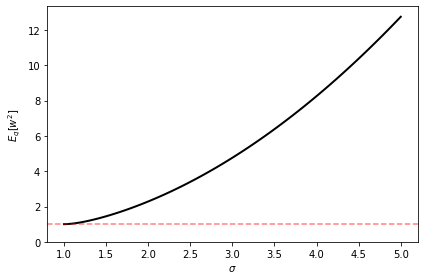

In [30]:
sigma = np.linspace(1., 5., 100) 
w2 = sigma**4 / (2.*sigma**2 - 1)
fig, ax = plt.subplots()
ax.plot(sigma, w2, color='k', lw=2)
ax.axhline(1., ls='--', color='r', alpha=0.5)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$E_q[w^2]$')
ax.set_ylim(0., None)
fig.tight_layout()

The effective sample size is

$$
ESS = \frac{\bigl(\mathbb E_q[w]\bigr)^2}{\mathbb E_q[w^2]} = \left(\frac{\sigma^4}{2\sigma^2-1}\right)^{-D/2}
$$

and decays with $D$. 

To see this more directly, let's try to characterize the typical set of a Gaussian model $\mathcal N\bigl(0, \sigma^2 I_D\bigr)$. Since the distribution is spherically symmetric, the distance from the center, $r=\|x\|$, follows the distribution

$$
p(r) \propto r^{D-1} e^{-r^2/2\sigma^2}\, .
$$

This implies that the pdf of the squared distance $r^2$ is a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) with shape parameter $D/2$ and scale $2\sigma^2$, therefore

$$
\mathbb E[\|x\|^2] = D\sigma^2, \,\,\, \text{var}[\|x\|^2] = 2\sigma^4 D . 
$$

The typical set is characterized by states with

$$
\|x\|^2 \approx \sigma^2 \bigl(D \pm \sqrt{2D}\bigr) = \sigma^2 D \bigl(1 \pm \sqrt{2/D}\bigr)\, .
$$

These states have an ever increasing distance from the origin, $\sim \sigma\sqrt{D}$, and concentrate in spherical shells that become thinner and thinner as $D$ increases. It will therefore be increasingly difficult to match the typical sets of the proposal and target pdf. At the same time, weights will fluctuate by factors of $\exp\{\pm\sqrt{2D}\}$, resulting in only a few dominant states and an effective sample size that drops to one.  

If we compare the probability of the maximum probability state $x_{\max} = 0$ with the probability of an element $x_{\text{typical}}$ of the typical set, we get:

$$
\frac{p(x_{\text{typical}})}{p(x_{\max})} \simeq \exp\left\{-\frac{1}{2}(D \pm \sqrt{2D}) \right\}
$$



In summary, the two major problems of importance sampling are: 

* Finding a good proposal $q$ whose typical set (region of states $x$ that are representative of $q$) overlaps with the typical set of the target $p$

* Weights are likely to vary by large factors, because the probabilities of points in a typical set, although similar to each other, still differ by factors of order $\exp(\sqrt{D})$, so the weights will too, unless $q$ is a near-perfect approximation to
$p$